# **Clustering**
Having cleaned and filtered our dataset, we narrowed our focus to high consumers defined as those whose bill amounts fall in the 90th percentile and above.

This focus is significant because, after consulting experts at the Nairobi Water Company, we learned that the most common driver of water loss is unbilled water. Despite widespread metering across the city, several structural challenges undermine accurate billing:

- **Busted pipes** – Water lost through leaks in the distribution network is never captured by meters, resulting in substantial unaccounted-for volumes.

- **Damaged metering systems** – When meters fail, all consumption during the downtime goes unbilled, creating revenue gaps.

- **Manual meter reading** – The reliance on manual readings introduces inefficiencies: human error in recording, skipped households or businesses, and overlooked regions. Together, these factors compound the issue of Non-Revenue Water (NRW).

To address this, the project seeks to identify hotspots of water loss and support the strategic rollout of smart metering systems. Clustering provides a powerful approach to this challenge.

By grouping high consumers into three distinct clusters, we can prioritize intervention:

- Highest consumers – the top priority for smart meter rollout, as losses here have the greatest financial impact.

- Higher consumers – secondary priority, important for scaling future rollouts.

- High consumers – still significant but not immediate rollout candidates.

Clustering is an unsupervised machine learning method that automatically groups similar data points without predefined labels. In this project, clustering not only segments consumers into the tiers above but also helps highlight outliers and reveal hidden usage patterns, both of which are critical for detecting leakages, theft, or under-billing risks

In [2]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import joblib
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
RANDOM_STATE = 42


Water billing example:

Normal: Usage is standard to bill.

Under-billed: High usage, low bill.

Over-billed: Low usage, high bill.


In [3]:
# Load dataset
df = pd.read_csv('../../Data/clean_data/Filtered.csv')

# Preview dataset
df.head()

,Unnamed: 0,REGION,ZONE,SUB_ZONE,INSTALLATION_KEY,INST_TYPE_CODE,INSTALLATION_TYPE_DESC,METER_SIZE,BILL_ESTIMATE_ACTUAL,BILL_VALID_INVALID,MAIN_SERVICE,SHADOW_SERVICE,WATER_AMOUNT,SEWER_AMOUNT,BILL_AMOUNT,BILL_VOLUME,MONTH,YEAR,NEGATIVE
0,8,WESTLANDS,KITUSURU,WAIYAKI WAY,CV-7000010,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,,7771.0,0.0,7771.0,111.0,August,2024.0,False
1,11,KASARANI,HUNTERS -MWIKI,HUNTERS,CV-7000013,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,,6424.0,0.0,6424.0,91.0,August,2024.0,False
2,39,WESTLANDS,KITUSURU,WAIYAKI WAY,CV-7000027,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,SEW,4904.0,3127.0,8031.0,71.0,August,2024.0,False
3,46,LANGATA,KAREN_LANGATA,OTIENDE LANGATA,CV-7000034,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,SEW,4162.0,2716.0,6878.0,62.0,August,2024.0,False
4,56,DAGORETTI,KAWANGWARE,RIARA,CV-7000116,COM,COMMERCIAL,2.0,ACTUAL,VALID,WAT,SEW,61550.0,40458.0,102008.0,785.0,August,2024.0,False


## **Feature Selection**
Feature selection is the act of choosing the most important variables for a model. It helps improve accuracy, reduce complexity, and also avoid overfitting. At the moment we have 19 columns but to carry out our clustering, we need columns that are relevant to our question and that will help us reach the best possible answer.

We are using the following columns;
1. `WATER_AMOUNT` → this is the direct measure of consumption. Critical.

2. `SEWER_AMOUNT` → this often correlates with water usage. Could be included, but might be redundant (we'll look out for multicollinearity).

3. `BILL_AMOUNT` → how much they’re billed. Tied to water + tariffs.

4. `BILL_VOLUME` → this is another consumption proxy. If strongly correlated with WATER_AMOUNT, you might drop one to avoid redundancy.

5. `METER_SIZE` → capacity, a proxy for expected usage. Very valuable

First, to make sure we have no redundacies, we are filtering the data to have the above named columns then checking for correlation.

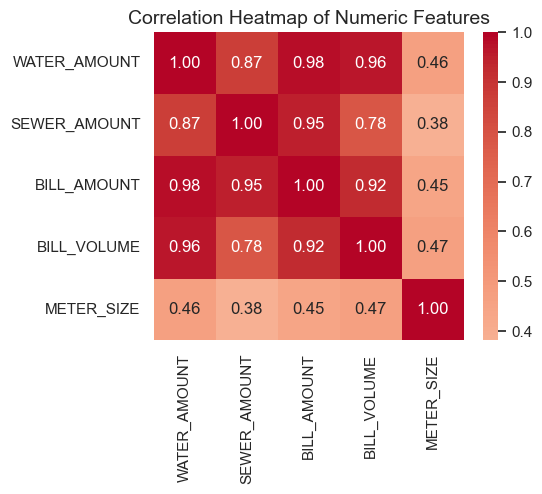

In [4]:
# Filter to remain with the above columns
clustering_data = df[['WATER_AMOUNT', 'SEWER_AMOUNT', 'BILL_AMOUNT', 'BILL_VOLUME', 'METER_SIZE']]

# Check correlation
num_cols = ['WATER_AMOUNT', 'SEWER_AMOUNT', 'BILL_AMOUNT', 'BILL_VOLUME', 'METER_SIZE']

# Compute correlation matrix
corr = df[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
plt.show()

From the visualization above, we see that `WATER_AMOUNT`, `SEWER_AMOUNT`, `BILL_AMOUNT` and `BILL_VOLUME` are highly correlated with all of them having correlations above 85%. To pinpoint exactly where the multicollinearity comes from, we are using VIF (Variance Inflation Factor). 

While correlation tells us what pairs of features are similar, VIF will help us decide which ones to actually keep for clustering.

In [5]:
# drop NaNs if any
X = df[num_cols].dropna()

# add constant for VIF calculation
X_const = add_constant(X)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(X.columns))]

print(vif_data)

        Feature            VIF
0  WATER_AMOUNT   86117.235558
1  SEWER_AMOUNT   30230.987080
2   BILL_AMOUNT  205408.686340
3   BILL_VOLUME      14.974460
4    METER_SIZE       1.283845


- `BILL_AMOUNT`, `WATER_AMOUNT`, and `SEWER_AMOUNT` are almost the same information, they’re strongly derived from each other, since `BILL_AMOUNT` = `WATER_AMOUNT` + `SEWER_AMOUNT`.

- Also, `BILL_VOLUME` is somewhat correlated with the billing amounts since cost is tied to consumption, but it still contains unique info about actual consumption.

- `METER_SIZE` is independent and safe.

For clustering, we need features that:

- Aren’t redundant,

- Capture meaningful variation,

- Don’t distort distances due to duplication.

So we are using;

- `BILL_VOLUME` → consumption behavior (core driver of clustering).

- `METER_SIZE` → capacity/size of installation, different customer classes.

- `BILL_AMOUNT` → this will help us have clusters influenced by spending patterns.

## **KMeans Clustering**
In this section we are going to cluster the data using the KMean clustering function based on the features we've chosen above. Clustering will help us find groups of consumers that share patterns. This process is going to involve;
- choosing the best number of clusters

- run KMeans 

- add the cluster labels back to the original data

- interpret what each cluster means

### **Baseline Model**
But first, for our baseline model and for easy interpretation, we are using the `BILL_AMOUNT` column to cluster first.

In [6]:
# Using one column for our baseline model
X = df[["BILL_AMOUNT"]]

# Scale features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Cluster
kmeans = KMeans(random_state=42)

# Predict the clusters
clusters = kmeans.fit_predict(X_scaled)

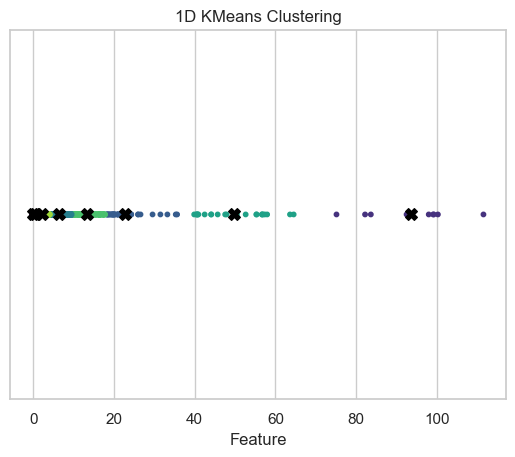

In [8]:
# Plot the clusters
centers = kmeans.cluster_centers_

# Plot the data on the x-axis, and just put zeros on y-axis
plt.scatter(X_scaled[:, 0], [0]*len(X_scaled), c=clusters, s=10, cmap='viridis')

# Plot the centers on the same line
plt.scatter(centers[:, 0], [0]*len(centers), c='black', s=70, marker='X')

plt.yticks([])  # hide y-axis ticks
plt.xlabel("Feature")
plt.title("1D KMeans Clustering")
plt.show()

- The plot above shows that most data values cluster between 0–40, showing the main group.

- Smaller clusters at higher values reveal outliers, which could be our targets.

#### *Choosing the best number of clusters*
In this part we'll be trying multiple values of k, that is number of clusters, and plot the inertia, how tight the groups are. We want a point where adding more clusters doesn't help much, this is the elbow method.

This will help us group the consumers into fewer groups.

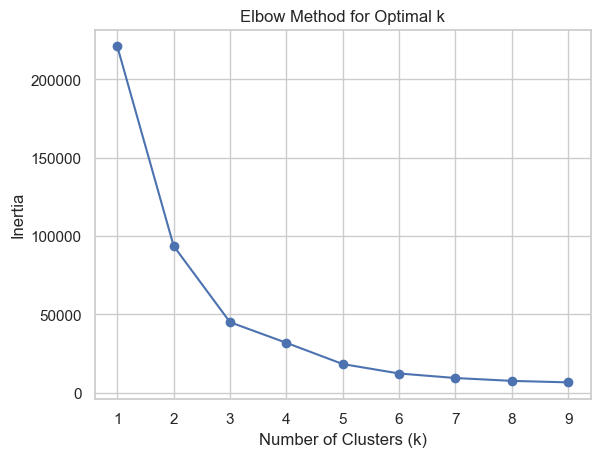

In [9]:
# Choose the best number of clusters.
inertia = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

Inertia measures how far each point is from the cluster's centroid, center of the cluster. The lower the distance, the better however, if the distance is too low it might mean overfitting.

The curve bends at k=3, forming an “elbow”, indicating that `k=3` gives the best balance of accuracy and simplicity.

So, through the elbow method, we choose to have 3 cluster points.

#### *Running KMeans and Adding the clusters to the original data.*
In the code above we have performed an elbow method and have decided to have 3 cluster groups. In the next code we will be running the KMeans and adding the clusters to the original dataset.

In [10]:
# Instantiate KMeans model, using the best n_clusters value as indicated by the plot above
kmeans = KMeans(n_clusters= 3, random_state= 42)

# Fit the model and predict on scaled data
clusters = kmeans.fit_predict(X_scaled)

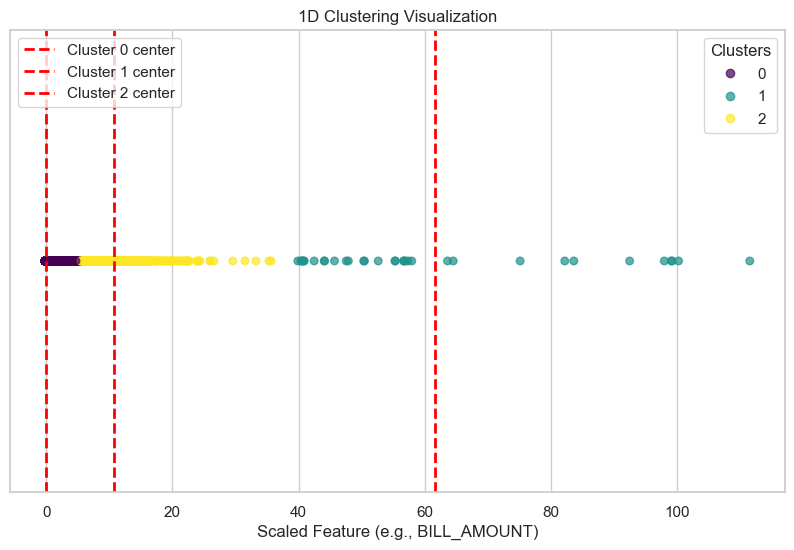

In [11]:
# Get cluster centers
centers = kmeans.cluster_centers_

# Plot the data points
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_scaled, np.zeros_like(X_scaled), c=clusters, cmap='viridis', s=30, alpha=0.7)

# Plot cluster centers as vertical lines
for i, c in enumerate(centers):
    plt.axvline(x=c, color='red', linestyle='--', linewidth=2, label=f'Cluster {i} center')

# Add legend for clusters (based on scatter plot colors)
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
plt.gca().add_artist(legend1)

# Add legend for cluster centers
plt.legend(loc="upper left")

plt.title("1D Clustering Visualization")
plt.xlabel("Scaled Feature (e.g., BILL_AMOUNT)")
plt.yticks([])  # remove y-axis since it's meaningless in 1D
plt.show()

The plot shows:
Black crosses mark the cluster centers along the feature axis (0 to 100+). We notice that the cllusters are mostly concentrated at lower feature values, with some sparse points at higher values.

- Consumers in cluster 0 have bill amounts between 0 and about 10, meaning that these consumers rank the lowest in our filtered data when it comes to bill amounts.

- Consumers in cluster 1 have the highest bill amounts from 40 to as high as around 150 scaled billed amounts. This indicates that this group contains our targeted customers.

- Customers in cluster 2 may be our higher consumers, with the lowest customer in this group having around 10 bill amount to the highest having around 35.

#### *Evaluation*
For this model we are using Calinski–Harabasz and Davies–Bouldin Metrics to evaluate our models. In clustering, we don’t have “ground truth labels,” so we need internal evaluation metrics that assess how well the clusters are formed based only on the data itself. Hence we decided on using the two of the most common and complementary metrics:

**Calinski–Harabasz Index (CH)**

This metric measures the ratio of between-cluster separation to within-cluster compactness. A higher CH score means that clusters are dense and well-separated.

We are using it in this project because we want to confirm that our segmentation of consumers results in tight, distinct groups that are meaningful for decision-making.

**Davies–Bouldin Index (DB)**

On the oter hand, this metric measures the average similarity between each cluster and its most similar one (based on distances and scatter). A lower DB score indicates better clustering, since clusters are compact and farther apart from each other.

We are using it here to guard against situations where clusters may look separated in one metric but still have overlap or fuzziness when compared pairwise.

- Ultimately, we are using them both for our evaluation because as much as CH is good, it only rewards separation, and doesn’t penalize overlapping or uneven clusters. The use of DB complements it by penalizing clusters that are too close or too spread out.

- By combining both, we ensure our chosen clustering configuration is not only statistically sound but also operationally useful for identifying water loss hotspots and consumer groups.

In [12]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# 1. Silhouette Score
silhouette = silhouette_score(X_scaled, clusters, sample_size=1000, random_state=42)

# 2. Calinski-Harabasz Index
calinski = calinski_harabasz_score(X_scaled, clusters)

# 3. Davies-Bouldin Index
davies = davies_bouldin_score(X_scaled, clusters)

print(f"Silhouette Score: {silhouette:.4f} (closer to 1 is better)")
print(f"Calinski-Harabasz Index: {calinski:.2f} (higher is better)")
print(f"Davies-Bouldin Index: {davies:.4f} (closer to 0 is better)")

Silhouette Score: 0.9831 (closer to 1 is better)
Calinski-Harabasz Index: 432076.77 (higher is better)
Davies-Bouldin Index: 0.4184 (closer to 0 is better)


These results show that our 3-cluster solution is both compact and well-separated:

- Consumers within the same cluster have very similar billing/consumption behavior.

- Different clusters represent clearly different patterns — e.g., truly high, higher, and highest consumers.

In our next step we are adding the clusters to the origin data for further analysis.

In [13]:
# Add cluster labels to the original dataset
clustering_data['baseline_cluster'] = clusters

# preview the dataset
clustering_data.head()

,WATER_AMOUNT,SEWER_AMOUNT,BILL_AMOUNT,BILL_VOLUME,METER_SIZE,baseline_cluster
0,7771.0,0.0,7771.0,111.0,0.5,0
1,6424.0,0.0,6424.0,91.0,0.5,0
2,4904.0,3127.0,8031.0,71.0,0.5,0
3,4162.0,2716.0,6878.0,62.0,0.5,0
4,61550.0,40458.0,102008.0,785.0,2.0,0


In [14]:
# Count how many consumers are in clusters.
clustering_data['baseline_cluster'].value_counts()

baseline_cluster
0    220484
2       435
1        33
Name: count, dtype: int64

This revelation cements our initial thoughts on the clusters. Despite cluster 1 having the highest paying customers, it has the least customers, whereas the customers in cluster 0 are the most.

Next wearevisualizing this just to understand the disparity betwen the three clusters.

#### *Cluster counts*

See how many consumers fall into each cluster:

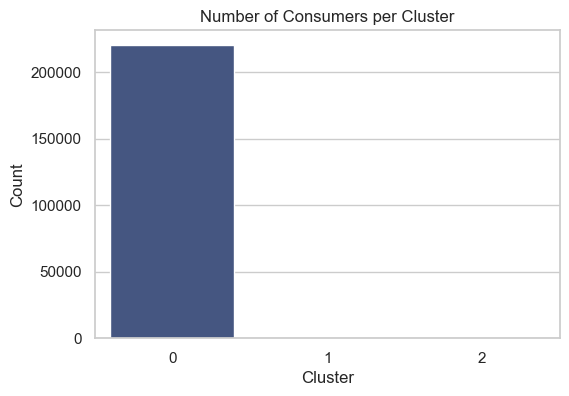

In [15]:
# Plot cluster count
plt.figure(figsize=(6,4))
sns.countplot(x='baseline_cluster', data=clustering_data, palette='viridis')
plt.title("Number of Consumers per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

Cluster 0 contains the most customers while the other 2 can't even be seen in the plot.

To further prove this, we are grouping the customers based on the clusters to understand better what each cluster contains.

In [16]:
# Statistical analysis of the clusters
clustering_data.groupby('baseline_cluster').mean(numeric_only= True)

,WATER_AMOUNT,SEWER_AMOUNT,BILL_AMOUNT,BILL_VOLUME,METER_SIZE
baseline_cluster,,,,,
0,1.465866e+04,7.561641e+03,2.222540e+04,203.074404,0.652093
1,5.692209e+06,3.841137e+06,9.533346e+06,71168.484848,7.515152
2,1.191462e+06,4.948155e+05,1.686277e+06,16854.636782,4.358621


#### *Average values per cluster*

This plot helps us compare usage patterns across clusters

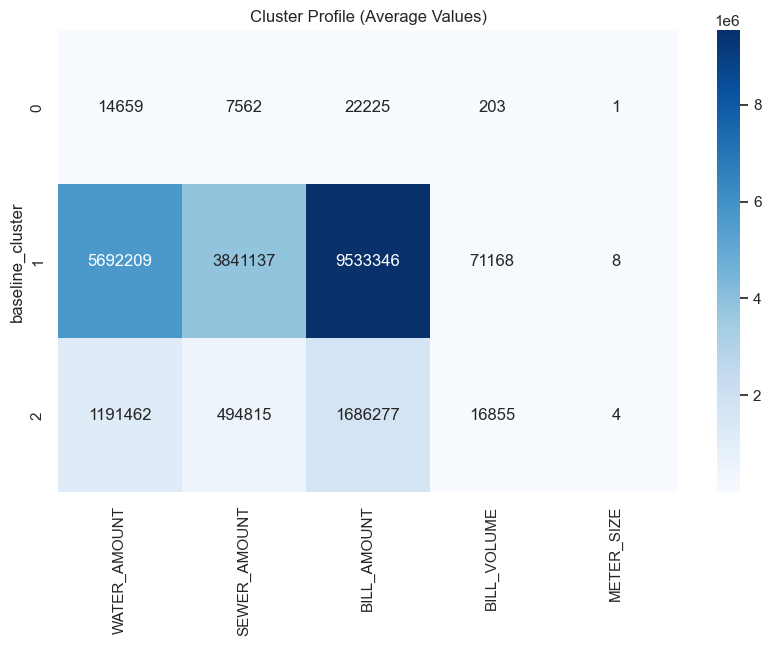

In [17]:
cluster_summary = clustering_data.groupby('baseline_cluster')[['WATER_AMOUNT','SEWER_AMOUNT','BILL_AMOUNT','BILL_VOLUME','METER_SIZE']].mean()

plt.figure(figsize=(10,6))
sns.heatmap(cluster_summary, annot=True, fmt=".0f", cmap="Blues")
plt.title("Cluster Profile (Average Values)")
plt.show()

Looking at the averages;

- **Cluster 0**: BILL_AMOUNT ≈ 22,225

- **Cluster 1**: BILL_AMOUNT ≈ 9.5 million

- **Cluster 2**: BILL_AMOUNT ≈ 1.7 million

It is safe to assume that;

- **Cluster 1** → Highest consumers (first priority for smart meters).

- **Cluster 2** → Higher consumers (second priority).

- **Cluster 0** → High consumers (still big, but relatively small compared to the others)

#### *Distribution by Cluster*

See how each feature is distributed across clusters:

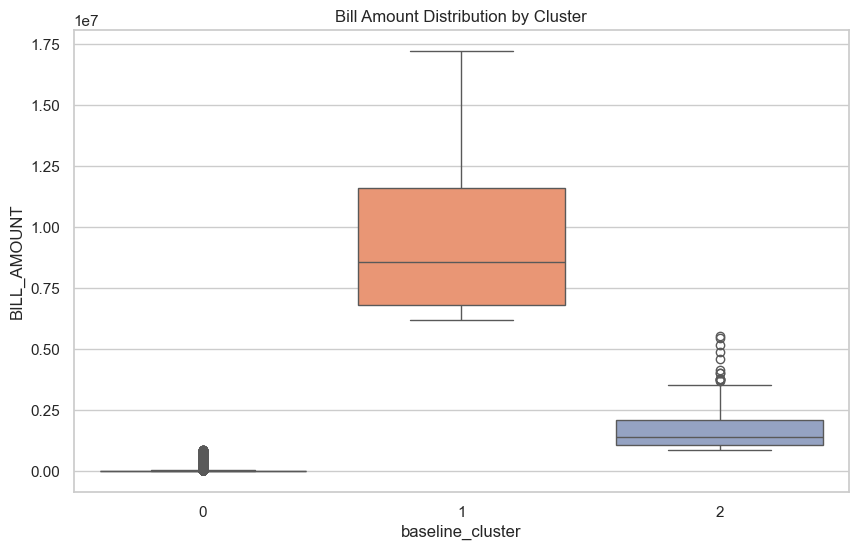

In [18]:
# Plot distribution by cluster
plt.figure(figsize=(10,6))
sns.boxplot(x='baseline_cluster', y='BILL_AMOUNT', data=clustering_data, palette='Set2')
plt.title("Bill Amount Distribution by Cluster")
plt.show()

### **Model 2**
In this part we are going to include the rest of our selected columns in our clustering, making things a little complex than they were in the previous model.

We are going to focus on ways to improve KMeans Performance as well as cluster based on multiple features. We are looking to play around with;

- Number of clusters (n_clusters) - This is the most important one — we already saw how the elbow method and silhouette score help you pick the best value.

- Initialization method (init) - Default is k-means++ (good in most cases), but you can try random too. k-means++ is usually faster and avoids poor local minima.

- Number of initializations (n_init) - KMeans runs multiple times with different initial seeds. Default in recent sklearn versions is n_init=10, but you can increase it (say, 50) for more stable results, especially on tricky data.

- Maximum iterations (max_iter) - Default is 300. If your data is complex, increasing this gives KMeans more time to converge.

We are also going to look at scaling & dimensionality reduction as well as employing pipelines and hyperparameter tuning.

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

In [20]:
# Add the rest of selected columns
X = clustering_data[['BILL_VOLUME', 'BILL_AMOUNT', 'METER_SIZE']]

# Build pipeline
kmeans_pipeline = Pipeline([
    ('scaler', StandardScaler()),        # Step 1: scale
    ('kmeans', KMeans(random_state=42)) # Step 3: cluster
])

# Fit pipeline
kmeans_pipeline.fit(X)

# Get cluster labels
clusters = kmeans_pipeline['kmeans'].labels_

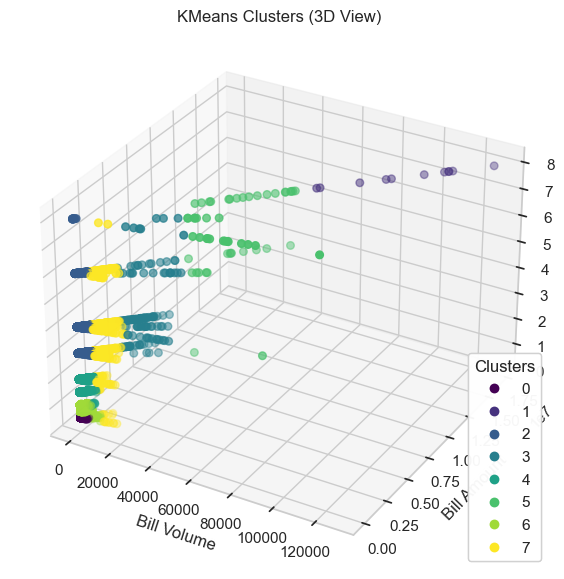

In [21]:
# Add cluster labels back to your data
X_plot = X.copy()
X_plot['Cluster'] = clusters

# 3D Scatterplot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_plot['BILL_VOLUME'], 
    X_plot['BILL_AMOUNT'], 
    X_plot['METER_SIZE'], 
    c=X_plot['Cluster'], 
    cmap='viridis',
    s=30
)

ax.set_xlabel('Bill Volume')
ax.set_ylabel('Bill Amount')
ax.set_zlabel('Meter Size')

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.title("KMeans Clusters (3D View)")
plt.show()

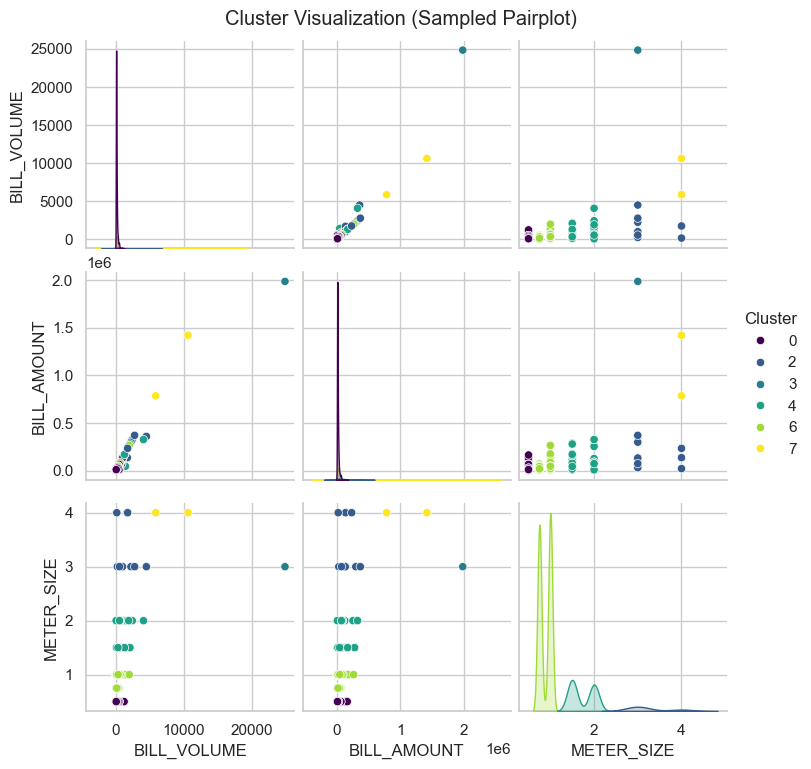

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample only 1000 rows for faster plotting
X_sample = X_plot.sample(n=1000, random_state=42)

sns.pairplot(X_sample, hue="Cluster", diag_kind="kde", palette="viridis")
plt.suptitle("Cluster Visualization (Sampled Pairplot)", y=1.02)
plt.show()


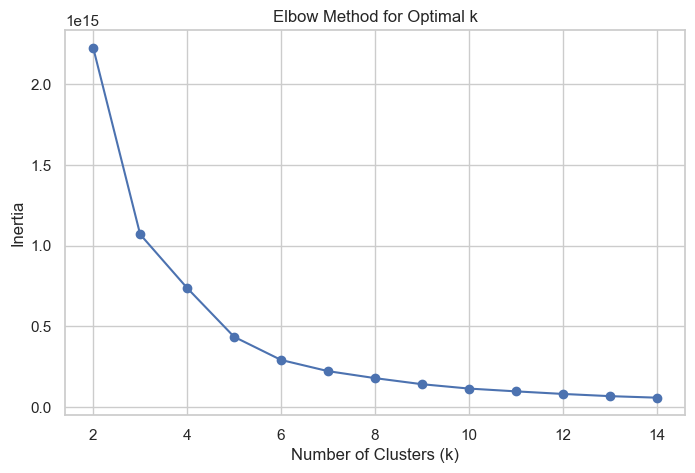

In [24]:
# Trying to find the best n_clusters
inertias = []
K_range = range(2, 15)  # Trying clusters from 2 to 14

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

From the plot, the biggest drops are from k=2 → k=3 → k=4 → k=5. After k≈5 or 6, the curve flattens, meaning that adding more clusters would only slightly improve inertia.

This leaves us with three likely candidates, that is;

- k=3

- k=4

- k=5

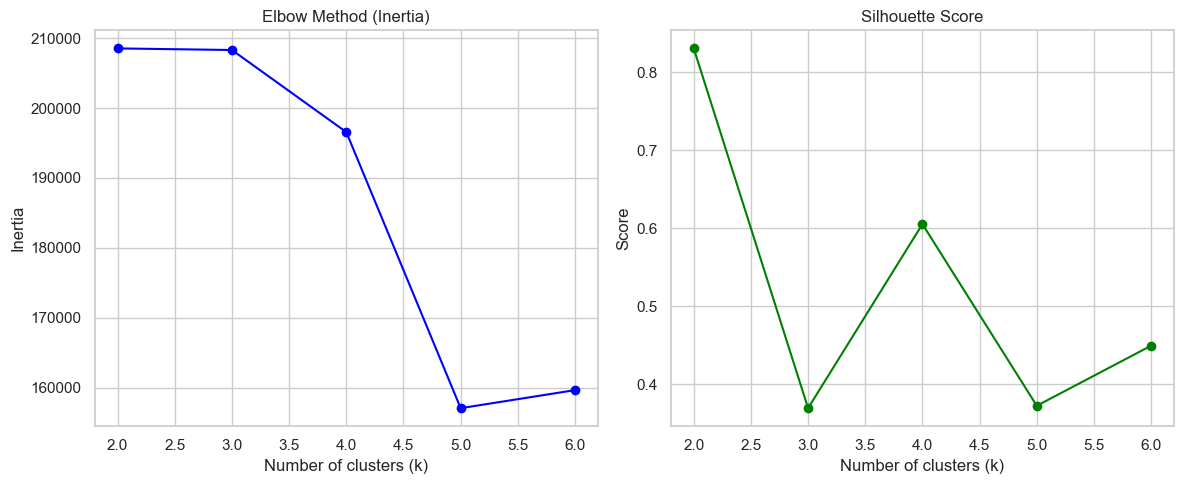

In [25]:
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# Define range of clusters
k_values = range(2, 7)  # smaller range for speed
inertia = []
silhouette_scores = []

for k in k_values:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    kmeans.fit(X_scaled)
    
    inertia.append(kmeans.inertia_)
    
    # silhouette with sampling for speed
    score = silhouette_score(X_scaled, kmeans.labels_, sample_size=2000, random_state=42)
    silhouette_scores.append(score)

# Plot results
plt.figure(figsize=(12,5))

# Elbow method
plt.subplot(1,2,1)
plt.plot(k_values, inertia, 'o-', color='blue')
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")

# Silhouette score
plt.subplot(1,2,2)
plt.plot(k_values, silhouette_scores, 'o-', color='green')
plt.title("Silhouette Score")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Score")

plt.tight_layout()
plt.show()

*Left Plot: Elbow Method*
From the plot, from k=2 → k=5, inertia drops sharply and after that the curve flattens, meaning additional clusters don’t reduce inertia by much but we already established that from our first inertia.

Also, the "elbow" appears around k=4 or k=5, suggesting that’s where the biggest gain in clustering quality happens.

*Right Plot: Silhouette Score*

Silhouette Score measures how well-separated clusters are (ranges -1 to 1, higher is better).

- At k=2, the score is highest (~0.84), meaning 2 clusters are very well-separated.

- At k=3, the score drops sharply (~0.37), which signals poor separation.

- At k=4, the score improves (~0.60), showing better structure.

- At k=5, the score again falls (~0.37), then slightly improves at k=6 (~0.45).

In conclusion, the most stable cluster structures are k=2 and k=4.

**Summary**

The elbow method points to k=4 or 5 whereas the Silhouette score strongly favors k=2 (best), but also shows k=4 as a decent balance. Since we are looking for a more detailed segmentation for business insights, we are choosing k=4 since it balances inertia reduction with decent silhouette.

#### **Hyperparameter Tuning**


In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [27]:
import itertools
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# Parameter grid
param_grid = {
    'n_clusters': [3, 4, 5],     
    # Number of initializations (more restarts → more reliable centroids)
    'n_init': [10, 20, 50, 100],

    # Maximum iterations (higher iterations → more chance to converge well)
    'max_iter': [300, 500, 1000],

    # Initialization method (different centroid seeding strategies)
    'init': ['k-means++', 'random']            
}

results = []

for n_clusters, n_init, max_iter, init in itertools.product(
    param_grid['n_clusters'], param_grid['n_init'], param_grid['max_iter'], param_grid['init']
):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter,
                             random_state=42, init= init, batch_size=1000)
    labels = kmeans.fit_predict(X_scaled)   
    
    # Use sample size to speed up silhouette
    score = silhouette_score(X_scaled, labels, sample_size=1000, random_state=42)
    
    results.append({
        'n_clusters': n_clusters,
        'n_init': n_init,
        'max_iter': max_iter,
        'silhouette_score': score,
        'inertia': kmeans.inertia_,
        'init' : init
    })

df_results = pd.DataFrame(results).sort_values(by="silhouette_score", ascending=False)
print(df_results)


    n_clusters  n_init  max_iter  silhouette_score        inertia       init
0            3      10       300          0.803747  429105.723605  k-means++
2            3      10       500          0.803747  429105.723605  k-means++
4            3      10      1000          0.803747  429105.723605  k-means++
15           3      50       500          0.802026  396720.093576     random
23           3     100      1000          0.802026  394387.871990     random
..         ...     ...       ...               ...            ...        ...
37           4      50       300          0.380297  495440.900457     random
41           4      50      1000          0.380297  495440.900457     random
67           5     100       300          0.365496  470040.850876     random
69           5     100       500          0.365496  470040.850876     random
71           5     100      1000          0.365496  470040.850876     random

[72 rows x 6 columns]


**Summary**
1. Silhouette Score

The best silhouette score is 0.8037 (very high!) with `n_clusters = 3, n_init = 10, max_iter = 300/500/1000`, suggesting 3 clusters is the most natural structure in the data.

2. Inertia

Inertia always decreases with more clusters, that is why we used it with silhouette.

In the analysis;

- 3 clusters, best silhouette (0.8037) has inertia ~429,106.

- 4 clusters reduce inertia to ~390,272 but silhouette drops to ~0.702.

- 5 clusters further reduce inertia (~395,063) but silhouette drops to ~0.720.

This means while inertia improves with more clusters, cluster quality worsens.

3. Effect of n_init

n_init is how many times KMeans restarts with different seeds. In the code above, `n_init = 10` already got the best result. Increasing to 20, 50, 100 did not improve silhouette, sometimes even hurt it (e.g., 0.7539 vs 0.8037). This means that the data is quite stable, it doesn’t need excessive retries.

4. Effect of max_iter

Increasing max_iter from 300 → 1000 didn’t change silhouette or inertia for the best case (3 clusters). Meaning the algorithm converged early, so higher iterations don’t add value.

**Overall Conclusion**:

- Best model: n_clusters=3, n_init=10, max_iter=300 (or higher)

- Silhouette = 0.8037 → excellent separation.

- Inertia = 429,105 → reasonably compact clusters.

#### **Principal Component Analysis (PCA)**
Having got the best performance, next we are adding dimension reduction. This is an important step in our project as we earlier identified that our selected features were highly correlated and even though we tried to fix the issue, we ended up with 2 other features that add value to the project but are still highly correlated.

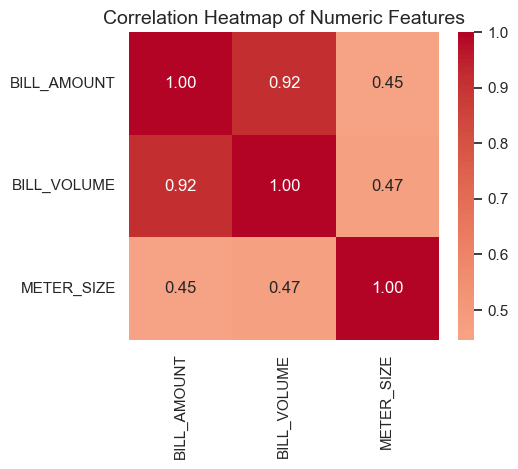

In [28]:
# Check correlation
num_cols = ['BILL_AMOUNT', 'BILL_VOLUME', 'METER_SIZE']

# Compute correlation matrix
corr = df[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
plt.show()

As shown above, `BILL_AMOUNT` and `BILL_VOLUME` are highly correlated, reducing the dimensions will be a great step in our process as it will help reduce noise. 

It is at the back of this that we introduce PCA into our clustering.

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Build pipeline
kmeans_pipeline = Pipeline([
    ('scaler', StandardScaler()),        # Step 1: scale
    ('pca', PCA(n_components=0.95, random_state= RANDOM_STATE)),        # Step 2: reduce dimensions (optional)
    ('kmeans', KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=500, random_state=42)) # Step 3: cluster
])

# Fit pipeline
kmeans_pipeline.fit(X)

# Get cluster labels
clusters = kmeans_pipeline['kmeans'].labels_

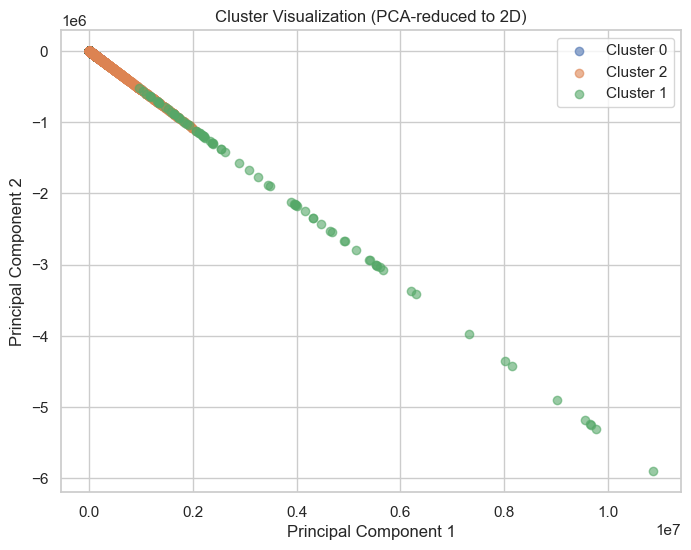

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Transform X using the pipeline steps before clustering
X_pca = kmeans_pipeline['pca'].transform(X)

# Put into a DataFrame for convenience
df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_plot['Cluster'] = clusters

# Scatter plot
plt.figure(figsize=(8,6))
for c in df_plot['Cluster'].unique():
    plt.scatter(df_plot[df_plot['Cluster']==c]['PC1'],
                df_plot[df_plot['Cluster']==c]['PC2'],
                label=f"Cluster {c}", alpha=0.6)

plt.title("Cluster Visualization (PCA-reduced to 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


In [32]:
X_transformed = kmeans_pipeline[:-1].transform(X)
labels = kmeans_pipeline['kmeans'].labels_


In [33]:
# 1. Silhouette Score
silhouette = silhouette_score(X_transformed, labels, sample_size=1000, random_state=42)

# 2. Calinski-Harabasz Index
calinski = calinski_harabasz_score(X_transformed, labels)

# 3. Davies-Bouldin Index
davies = davies_bouldin_score(X_transformed, labels)

print(f"Silhouette Score: {silhouette:.4f} (closer to 1 is better)")
print(f"Calinski-Harabasz Index: {calinski:.2f} (higher is better)")
print(f"Davies-Bouldin Index: {davies:.4f} (closer to 0 is better)")

Silhouette Score: 0.8824 (closer to 1 is better)
Calinski-Harabasz Index: 198796.54 (higher is better)
Davies-Bouldin Index: 0.5957 (closer to 0 is better)


**PCA-based clustering results:**

`Silhouette Score= 0.8824`, this means your clusters are very well-separated and internally consistent.

Before PCA, our silhouette was 0.80, which clearly indicates that PCA has improved cohesion + separation dramatically.

`Calinski-Harabasz Index= 198,796.54`, the higher the index, the better separation between clusters relative to within-cluster variance. At first, this might look like a drop in “quality,” but  PCA reduced dimensionality, often lowers absolute CH values.

`Davies-Bouldin Index= 0.5957`, the closer to 0 the index is, the better it is. This indicates that the clusters are a 

In general, PCA has significantly boosted Silhouette Score, which is the most intuitive measure, meaning that the clusters are more cleanly separated. This is a great result because interpretability and reduced dimensionality make it easier to visualize clusters and explain patterns to stakeholders.


In [34]:
# Add cluster labels to the original dataset
clustering_data['final_cluster'] = clusters

# preview the dataset
clustering_data.head()

,WATER_AMOUNT,SEWER_AMOUNT,BILL_AMOUNT,BILL_VOLUME,METER_SIZE,baseline_cluster,final_cluster
0,7771.0,0.0,7771.0,111.0,0.5,0,0
1,6424.0,0.0,6424.0,91.0,0.5,0,0
2,4904.0,3127.0,8031.0,71.0,0.5,0,0
3,4162.0,2716.0,6878.0,62.0,0.5,0,0
4,61550.0,40458.0,102008.0,785.0,2.0,0,2


In [35]:
clustering_data['final_cluster'].value_counts()

final_cluster
0    212193
2      8678
1        81
Name: count, dtype: int64

final_cluster          0   1     2
baseline_cluster                  
0                 212193   0  8291
1                      0  33     0
2                      0  48   387


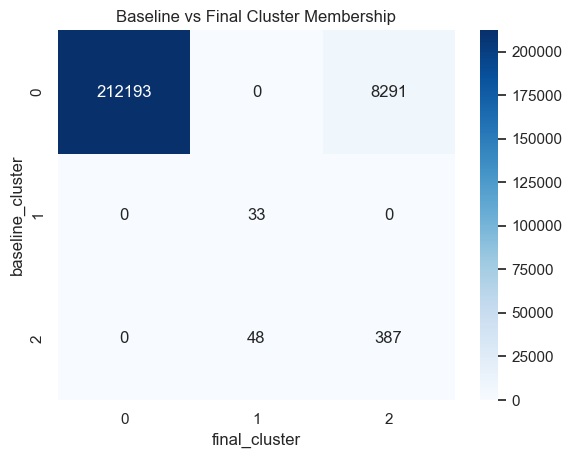

In [36]:
# Cross-tabulate cluster assignments
comparison = pd.crosstab(clustering_data['baseline_cluster'], clustering_data['final_cluster'])

print(comparison)

sns.heatmap(comparison, annot=True, fmt="d", cmap="Blues")
plt.title("Baseline vs Final Cluster Membership")
plt.show()

**Baseline cluster 0** → Here, 212,193 points stayed in final cluster 0 as 8,291 points moved to final cluster 2. This means most of cluster 0 stayed stable, but a small subgroup was reclassified after PCA.

**Baseline cluster 1** → All 33 points went to final cluster 1, proving that the model is very stable. PCA confirmed the group.

**Baseline cluster 2** → In this cluster, 48 points moved to final cluster 1 whereas 387 points stayed in final cluster 2. Despite cluster 2 getting a bit split up, most stayed consistent.

**Overall takeaway**

- High consistency: The largest cluster (0) is very stable, which means the PCA transformation preserved its structure.

- Small shifts: The smaller clusters (1 & 2) saw some reassignments, which suggests PCA helped refine or separate some borderline points.

- Better separation: Since the evaluation metrics improved after PCA (e.g., silhouette ↑), these shifts are most probably corrections, and not errors.

In the next cell, we are tring to understand the clusters better by exploring the means of every other feature.

               WATER_AMOUNT  SEWER_AMOUNT  BILL_AMOUNT  BILL_VOLUME  \
final_cluster                                                         
0                  11745.24       6039.65     17790.11       161.82   
1                3937477.74    1804158.32   5741636.06     56486.64   
2                 129861.27      67010.29    196873.42      1791.11   

               METER_SIZE  
final_cluster              
0                    0.58  
1                    7.17  
2                    2.56  


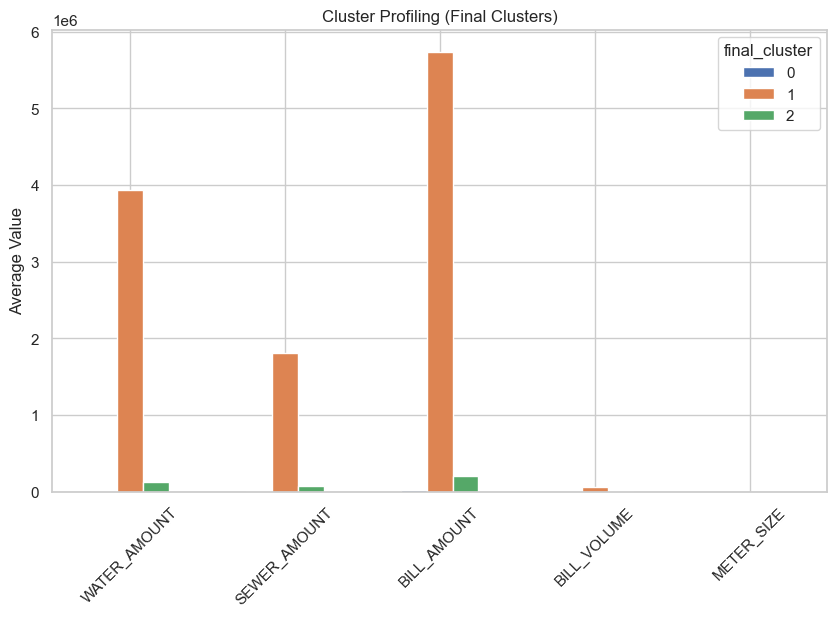

In [37]:
# Create a profile of every cluster
profile = clustering_data.groupby('final_cluster')[['WATER_AMOUNT','SEWER_AMOUNT',
                                       'BILL_AMOUNT','BILL_VOLUME','METER_SIZE']].mean().round(2)
print(profile)

# Plot the profile
profile.T.plot(kind='bar', figsize=(10,6))
plt.title("Cluster Profiling (Final Clusters)")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.show()

##### *Interpretation by Cluster*

**Cluster 0**

`WATER_AMOUNT = 11,745`, `SEWER_AMOUNT = 6,040`, `BILL_AMOUNT = 17,790`, `BILL_VOLUME = 162`, and `METER_SIZE = 0.58`. By the look of cluster 0's profile, this looks like small users (households, small shops) characterized by:

- Very low consumption.

- Very small bills.

- Small meter sizes (~½ inch).

**Cluster 1**

`WATER_AMOUNT = 3,937,478`, `SEWER_AMOUNT = 1,804,158`, `BILL_AMOUNT = 5,741,636`, `BILL_VOLUME = 56,487`, and `METER_SIZE = 7.17`. This cluster contains the big consumers (industries, large businesses, commercial entities) characterized by:

- Extremely high consumption.

- Very large bills.

- Meter sizes around 7 inches, which is huge.

This group likely contributes the majority of revenue.

**Cluster 2**

`WATER_AMOUNT = 129,861`, `SEWER_AMOUNT = 67,010`, `BILL_AMOUNT = 196,873`, `BILL_VOLUME = 1,791`, and `METER_SIZE = 2.56`. This looks like medium users (apartment blocks, schools, mid-sized businesses) characterized by:

- Moderate water usage.

- edium-sized bills.

- Meter sizes ~2.5 inches.


| Cluster | Description |
| ------- | ----------- |
| Cluster 0 | Small users (residential/small-scale) |
| Cluster 2 | Medium users (institutions, mid-level businesses) |
| Cluster 1 | Large users (factories, malls, commercial heavyweights) |

For further analysis, we are adding the final cluster to the original data. This is an important step as it will help us make better recommendations as well as detailed ones that will help the company better.

In [38]:
# Add cluster labels to the original dataset
df['final_cluster'] = clusters

# preview the dataset
df.head()

,Unnamed: 0,REGION,ZONE,SUB_ZONE,INSTALLATION_KEY,INST_TYPE_CODE,INSTALLATION_TYPE_DESC,METER_SIZE,BILL_ESTIMATE_ACTUAL,BILL_VALID_INVALID,MAIN_SERVICE,SHADOW_SERVICE,WATER_AMOUNT,SEWER_AMOUNT,BILL_AMOUNT,BILL_VOLUME,MONTH,YEAR,NEGATIVE,final_cluster
0,8,WESTLANDS,KITUSURU,WAIYAKI WAY,CV-7000010,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,,7771.0,0.0,7771.0,111.0,August,2024.0,False,0
1,11,KASARANI,HUNTERS -MWIKI,HUNTERS,CV-7000013,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,,6424.0,0.0,6424.0,91.0,August,2024.0,False,0
2,39,WESTLANDS,KITUSURU,WAIYAKI WAY,CV-7000027,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,SEW,4904.0,3127.0,8031.0,71.0,August,2024.0,False,0
3,46,LANGATA,KAREN_LANGATA,OTIENDE LANGATA,CV-7000034,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,SEW,4162.0,2716.0,6878.0,62.0,August,2024.0,False,0
4,56,DAGORETTI,KAWANGWARE,RIARA,CV-7000116,COM,COMMERCIAL,2.0,ACTUAL,VALID,WAT,SEW,61550.0,40458.0,102008.0,785.0,August,2024.0,False,2


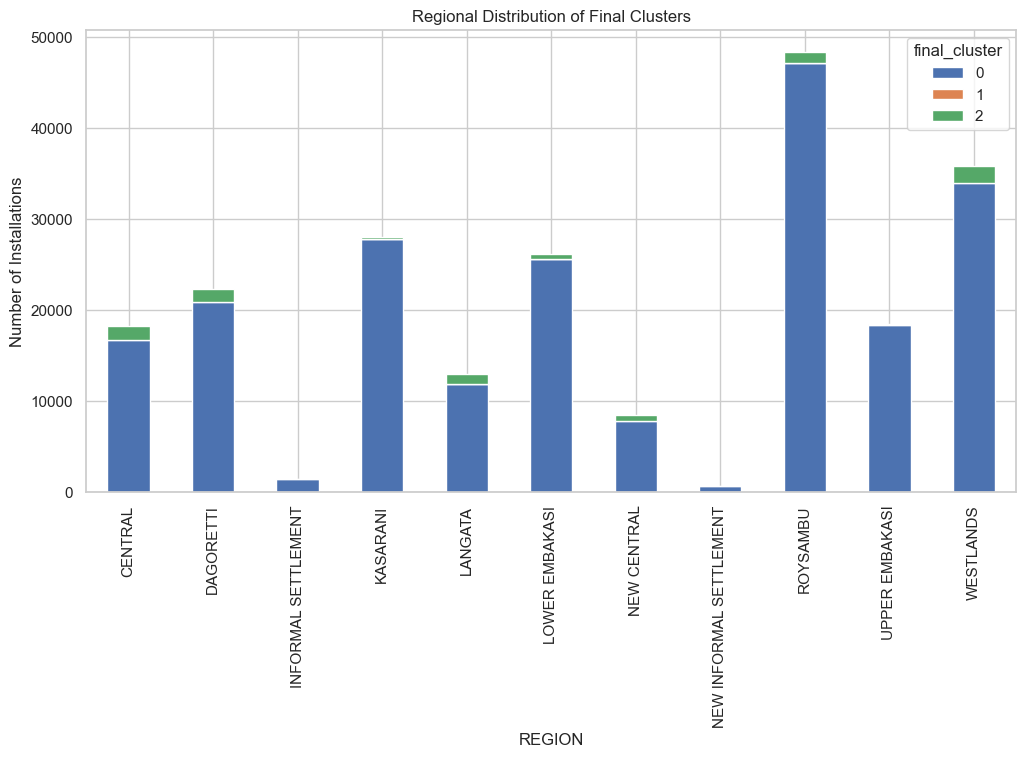

In [39]:
geo_counts = df.groupby(['REGION','final_cluster']).size().unstack(fill_value=0)

geo_counts.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title("Regional Distribution of Final Clusters")
plt.ylabel("Number of Installations")
plt.show()

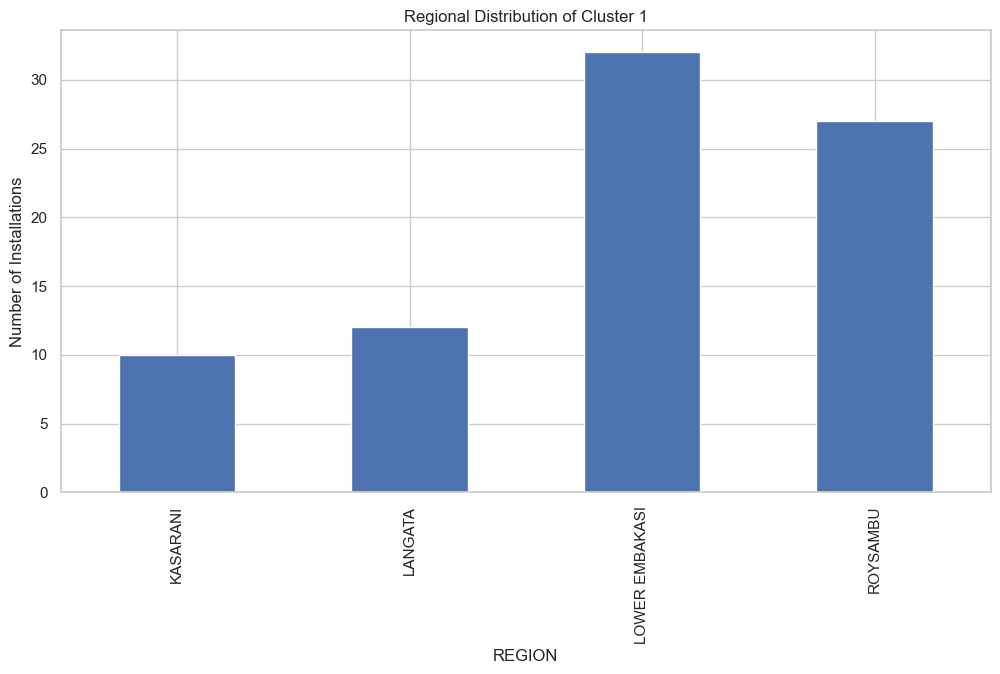

In [40]:
cluster_1 = df[df['final_cluster'] == 1]

dt = cluster_1.groupby(['REGION']).size()

dt.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title("Regional Distribution of Cluster 1")
plt.ylabel("Number of Installations")
plt.show()

From the plot above, we notice that `lower Embakasi` has the highest number of cluster 1 consumers. From that observation, we recommend that the water company rollout the smart metering there first before moving to other reions such as Roysambu, Langata and Kasarani.



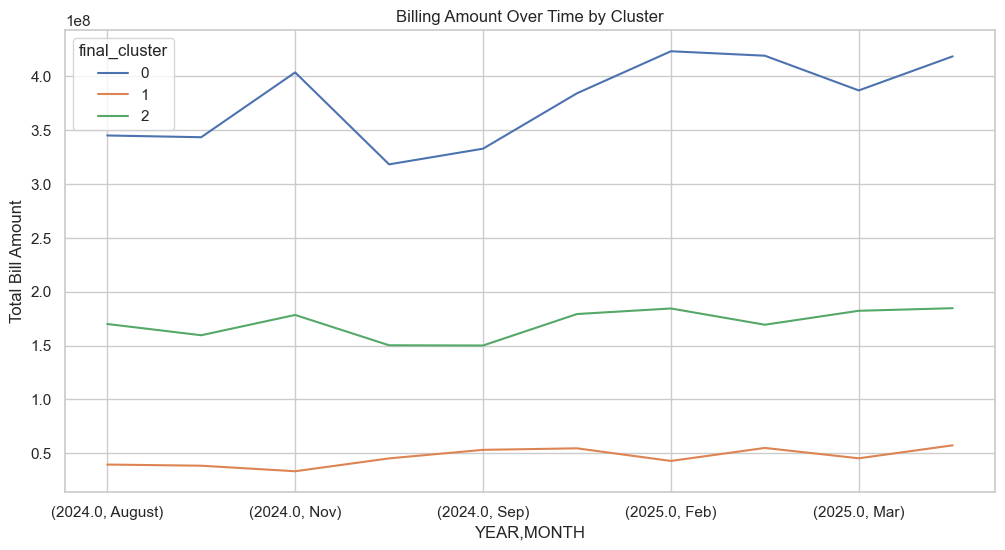

In [41]:
time_trends = df.groupby(['YEAR','MONTH','final_cluster'])['BILL_AMOUNT'].sum().unstack(fill_value=0)

time_trends.plot(figsize=(12,6))
plt.title("Billing Amount Over Time by Cluster")
plt.ylabel("Total Bill Amount")
plt.show()


Interpretation:

Spikes/drops → leaks, seasonal demand, or reporting issues.

Strong evidence for aligning smart metering with peak usage months.

In [42]:
# Group water amount by cluster, year, and month
roi = df.groupby(['YEAR','MONTH','final_cluster'])['WATER_AMOUNT'].sum().reset_index()

# Calculate % share within just the filtered dataset
roi['percent_of_filtered'] = roi['WATER_AMOUNT'] / roi.groupby(['YEAR','MONTH'])['WATER_AMOUNT'].transform('sum') * 100


In [43]:
roi

,YEAR,MONTH,final_cluster,WATER_AMOUNT,percent_of_filtered
0,2024.0,August,0,2.284656e+08,62.074037
1,2024.0,August,1,2.425964e+07,6.591338
2,2024.0,August,2,1.153281e+08,31.334626
3,2024.0,Dec,0,2.266432e+08,63.068307
4,2024.0,Dec,1,2.501215e+07,6.960164
5,2024.0,Dec,2,1.077061e+08,29.971529
6,2024.0,Nov,0,2.675072e+08,65.003363
7,2024.0,Nov,1,2.458321e+07,5.973638
8,2024.0,Nov,2,1.194379e+08,29.022999
9,2024.0,Oct,0,2.113263e+08,61.448832


In [44]:
import pandas as pd

# Load your csv
production_df = pd.read_csv('../../Data/raw_data/Water_Produced.csv')

# Parse 'month' column (e.g., 'Jul-24')
production_df['month'] = pd.to_datetime(production_df['MONTH'], format='%b-%y')

# Extract year and month number
production_df['YEAR'] = production_df['month'].dt.year
production_df['MONTH'] = production_df['month'].dt.month

# Drop or keep original month column
production_df = production_df.drop(columns=['month', 'Unnamed: 2'])

print(production_df.head())


   MONTH TOTAL PRODUCTION  (m3)  YEAR
0      7          15,438,266.56  2024
1      8          16,286,171.66  2024
2      9          16,096,105.72  2024
3     10          15,093,036.26  2024
4     11          16,366,360.14  2024


In [45]:
print(roi['MONTH'].head(10))
print(roi['MONTH'].dtype)


0    August
1    August
2    August
3       Dec
4       Dec
5       Dec
6       Nov
7       Nov
8       Nov
9       Oct
Name: MONTH, dtype: object
object


In [46]:
import calendar
import numpy as np

# Build maps for both short and full names
month_map_short = {m.lower(): i for i, m in enumerate(calendar.month_abbr) if m}
month_map_full = {m.lower(): i for i, m in enumerate(calendar.month_name) if m}

def robust_month_parser(val):
    if pd.isna(val):
        return np.nan
    val = str(val).strip().lower()
    
    # If already numeric
    if val.isdigit():
        return int(val)
    
    # Match short names (jan, feb, mar…)
    if val in month_map_short:
        return month_map_short[val]
    
    # Match full names (january, february…)
    if val in month_map_full:
        return month_map_full[val]
    
    return np.nan  # fallback

# Apply to both dataframes
roi["MONTH"] = roi["MONTH"].apply(robust_month_parser)
production_df["MONTH"] = production_df["MONTH"].apply(robust_month_parser)

# Convert YEAR safely
roi["YEAR"] = pd.to_numeric(roi["YEAR"], errors="coerce").astype("Int64")
production_df["YEAR"] = pd.to_numeric(production_df["YEAR"], errors="coerce").astype("Int64")

# Clean production volume
production_df['TOTAL PRODUCTION  (m3)'] = (
    production_df['TOTAL PRODUCTION  (m3)']
    .astype(str)
    .str.replace(",", "")
    .astype(float)
)

# Merge
roi = roi.merge(production_df, on=["YEAR", "MONTH"], how="left")

# ROI % of production
roi["percent_of_production"] = (
    (roi["WATER_AMOUNT"] / roi["TOTAL PRODUCTION  (m3)"]) * 100)


In [47]:
# ROI % of production
roi["percent_of_production"] = (
    (roi["WATER_AMOUNT"] / roi["TOTAL PRODUCTION  (m3)"]) * 100)

In [48]:
roi[['YEAR','MONTH','final_cluster','WATER_AMOUNT',
     'percent_of_filtered','percent_of_production']]


,YEAR,MONTH,final_cluster,WATER_AMOUNT,percent_of_filtered,percent_of_production
0,2024,8,0,2.284656e+08,62.074037,1402.819324
1,2024,8,1,2.425964e+07,6.591338,148.958506
2,2024,8,2,1.153281e+08,31.334626,708.135334
3,2024,12,0,2.266432e+08,63.068307,1383.761067
4,2024,12,1,2.501215e+07,6.960164,152.710685
5,2024,12,2,1.077061e+08,29.971529,657.595498
6,2024,11,0,2.675072e+08,65.003363,1634.494458
7,2024,11,1,2.458321e+07,5.973638,150.205750
8,2024,11,2,1.194379e+08,29.022999,729.776566
9,2024,10,0,2.113263e+08,61.448832,1400.157716


## **Gaussian Mixture Models (GMM)**
At this point we have successfully managed to group our consumers into 3 sections, that is;
- Highest consumers

- Higher consumers

- High consumers

Despite having achieved favorable performance, it is important to note that `KMeans clustering` assumes clusters are circular blobs, equally sized, with hard boundaries, which is rarely the case with real data. Real-world data isn’t always circular, clusters can be oval, skewed, or overlapping. 

It is at the back of this that we introduce the Guassian Mixture Models (GMM). This is a probabilistic clustering method that models data as a combination of multiple Gaussian distributions. Unlike K-Means, which assigns each point to exactly one cluster, GMM gives probabilities of belonging to each cluster (soft clustering).

Some of the advantages this model has over KMeans include:

- Handles clusters of different shapes and sizes (elliptical, not just spherical).

- More flexible when clusters overlap.

- Provides probabilistic assignments, useful for identifying borderline or uncertain cases.

The model assumes data is generated from k Gaussian distributions and uses the Expectation-Maximization (EM) algorithm to estimate cluster parameters (means, covariances, and weights) and assigns points to clusters based on highest probability.

This section is about attempting to get a better understanding of the consumers at hand, understanding that one consumer might have characteristics from different clusters and that it all matters.

This model will;
- help identify customer segments with distinct consumption/billing patterns.

- be useful when billing data shows overlapping behaviors (e.g., small businesses vs. large domestic users).

and also, the probabilistic nature helps flag customers with uncertain billing patterns (potential anomalies).

In [49]:
# Select billing features
billing_features = ["WATER_AMOUNT", "SEWER_AMOUNT", "BILL_AMOUNT", "BILL_VOLUME"]
X = df[billing_features].fillna(0).values


In [50]:
# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### **Model Selection**
To choose the best model, we have to select the optimal number of clusters (k), this can be chosen using BIC (Bayesian Information Criterion) or AIC (Akaike Information Criterion), where lower scores indicate a better fit with fewer penalties for complexity.

- BIC (Bayesian Information Criterion): balances model fit vs. complexity (penalizes adding too many clusters).

- AIC (Akaike Information Criterion): similar, but penalizes complexity less.

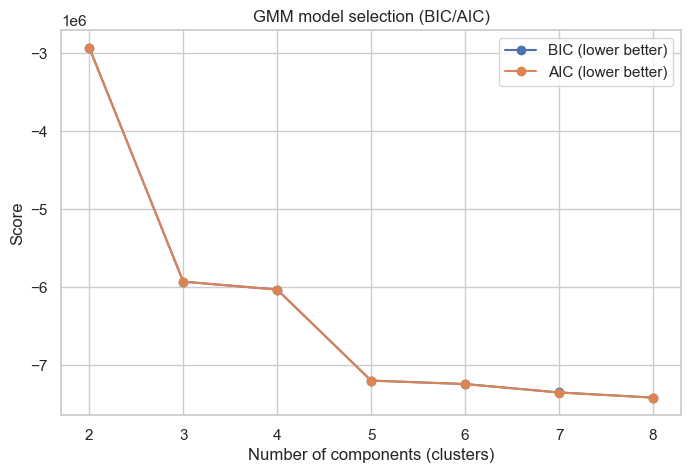

In [51]:
#  Step 1: Select number of clusters using BIC/AIC 

n_components = range(2, 9)
bics = []
aics = []

for k in n_components:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_scaled)
    bics.append(gmm.bic(X_scaled))
    aics.append(gmm.aic(X_scaled))

plt.figure(figsize=(8,5))
plt.plot(n_components, bics, marker='o', label="BIC (lower better)")
plt.plot(n_components, aics, marker='o', label="AIC (lower better)")
plt.title("GMM model selection (BIC/AIC)")
plt.xlabel("Number of components (clusters)")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

According to the plot;
- At 2 clusters, AIC/BIC is very high (poor fit).

- At 3 clusters, there’s a huge drop → model fit improves a lot.

- From 3 → 4, the drop is much smaller.

- From 4 → 5, there’s another noticeable drop.

- From 5 → 8, the scores keep decreasing slightly, but not by much.

The biggest gain is between 2 → 3 clusters, which is a major improvement, the next meaningful gain is at 5 clusters and beyong that the improvement is small risking overfitting. This leaves us with 2 choices;
- 3 clusters → simple, interpretable, avoids overfitting.

- 5 clusters → captures more nuance, but at the cost of complexity.

Since we are looking for something business-friendly and explainable, we are going to go ahead and use 3 clusters for our model. This is because it is important to have fewer groups to work with as this is still a new operation for the company, the groups need not complicate matters for the company further.

In [52]:
#  Step 2: Fit final GMM with optimal k 
best_k = 3
final_gmm = GaussianMixture(n_components=best_k, random_state=42)
df["gmm_cluster"] = final_gmm.fit_predict(X_scaled)

print(f"Best number of clusters by BIC: {best_k}")

Best number of clusters by BIC: 3


In [53]:
from sklearn import metrics

labels = final_gmm.predict(X_scaled)  # hard assignments
sil = metrics.silhouette_score(X_scaled, labels, sample_size=1000, random_state=42)
ch = metrics.calinski_harabasz_score(X_scaled, labels)
db = metrics.davies_bouldin_score(X_scaled, labels)

print(f"Silhouette Score: {sil:.4f}")
print(f"Calinski-Harabasz Index: {ch:.2f}")
print(f"Davies-Bouldin Index: {db:.4f}")


Silhouette Score: 0.6561
Calinski-Harabasz Index: 5529.27
Davies-Bouldin Index: 3.0460


In [54]:
# After fitting
probabilities = final_gmm.predict_proba(X)

# Example: first 5 consumers
import pandas as pd
prob_df = pd.DataFrame(probabilities, columns=[f"Cluster_{i}" for i in range(probabilities.shape[1])])
print(prob_df.head())


   Cluster_0  Cluster_1  Cluster_2
0        0.0        0.0        1.0
1        0.0        0.0        1.0
2        0.0        0.0        1.0
3        0.0        0.0        1.0
4        0.0        0.0        1.0


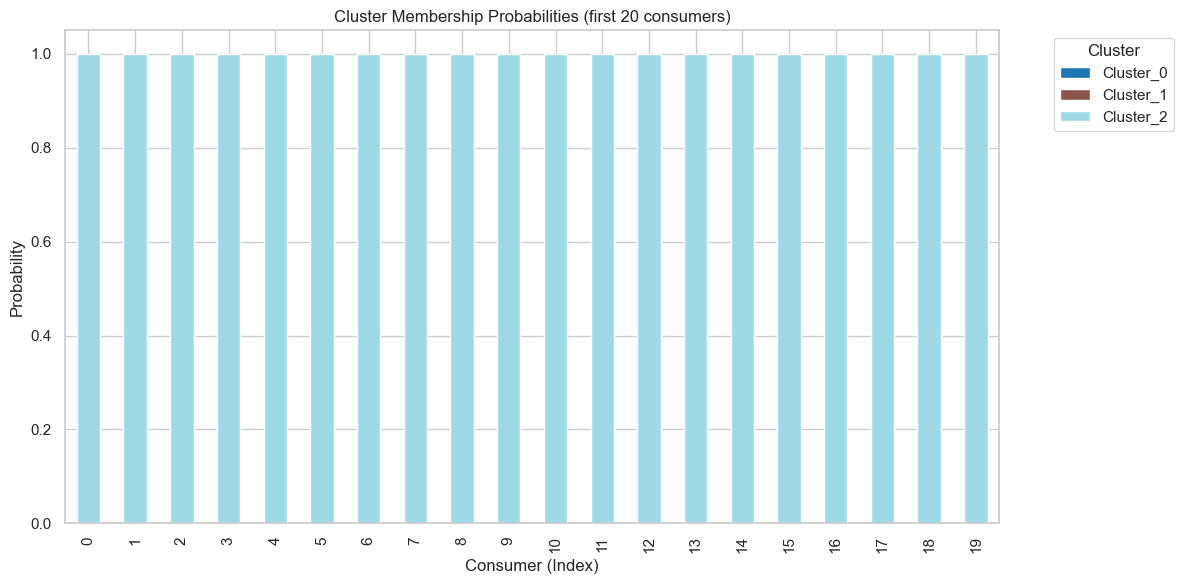

In [58]:
import matplotlib.pyplot as plt

# Use index instead of "Consumer_ID"
prob_df.head(20).plot(
    kind="bar", stacked=True, figsize=(12,6), colormap="tab20"
)

plt.title("Cluster Membership Probabilities (first 20 consumers)")
plt.ylabel("Probability")
plt.xlabel("Consumer (Index)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


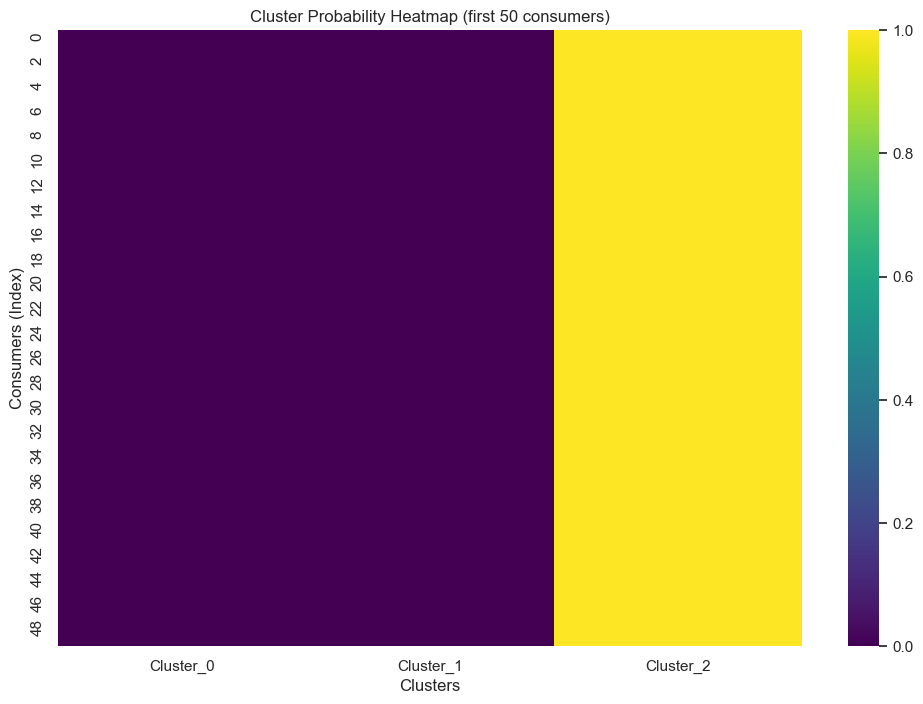

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(prob_df.head(50), cmap="viridis", annot=False)
plt.title("Cluster Probability Heatmap (first 50 consumers)")
plt.xlabel("Clusters")
plt.ylabel("Consumers (Index)")
plt.show()


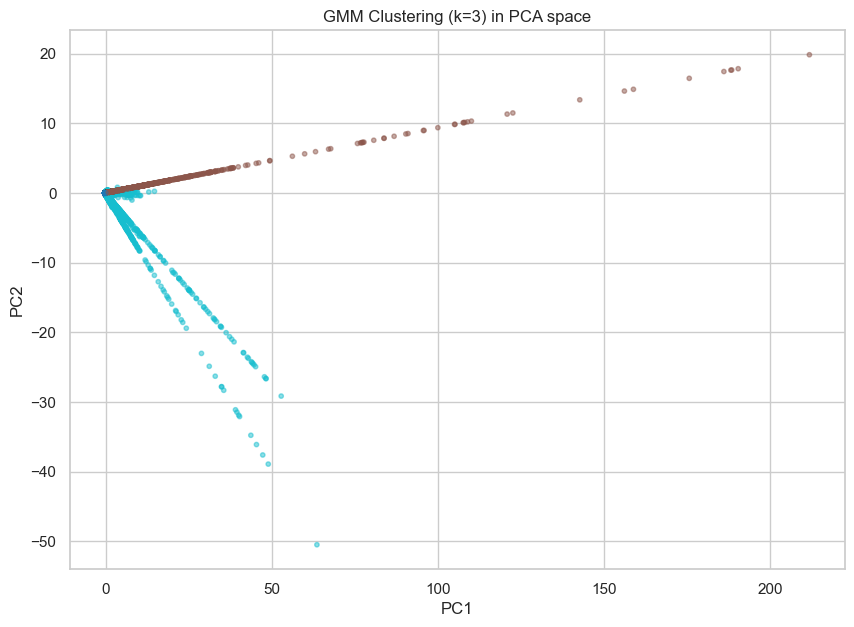

In [62]:
#  Step 3: Visualize in PCA space 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,7))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df["gmm_cluster"], cmap="tab10", alpha=0.5, s=10)
plt.title(f"GMM Clustering (k={best_k}) in PCA space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [72]:
#  Step 4: Cluster profiles (means in original scale) 
cluster_profiles = df.groupby("gmm_cluster")[billing_features].mean()
print("Cluster profiles (original scale):")
print(cluster_profiles)

Cluster profiles (original scale):
             WATER_AMOUNT  SEWER_AMOUNT    BILL_AMOUNT  BILL_VOLUME
gmm_cluster                                                        
0             7990.967096   3764.618116   11755.585212   111.126456
1            62795.109952  41471.762385  104266.872337   801.255585
2            73764.072585   7020.675852   80933.497135  1276.035601


## **Predictive Modeling**


Objective
Build models to predict customer billing/consumption and classify customer behavior.

Data Prep

Features: WATER_AMOUNT, SEWER_AMOUNT, BILL_AMOUNT, BILL_VOLUME, REGION, INST_TYPE_CODE.

Steps: One-hot encoding (categorical), scaling (numeric), 80/20 train-test split.

Models

Regression: Linear Regression, Random Forest Regressor.

Classification: Logistic Regression (99.6%), Random Forest Classifier (99.9%), XGBoost Classifier (99.8%).

Evaluation

Metrics: Accuracy, Precision, Recall, F1-score.

Visuals: Confusion Matrices, Classification Report Bar Plots, Actual vs Predicted Scatter Plots.

Findings

All classifiers performed >99% accuracy.

Random Forest gave best recall for high consumers.

Models closely matched actual consumption trends.

Use Cases

Forecast billing and demand.

Identify high-value or at-risk customers.

Detect anomalies in water consumption.



In [73]:
# Import Libraries

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb


from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
import matplotlib.pyplot as plt

In [75]:
print(df.columns)


Index(['Unnamed: 0', 'REGION', 'ZONE', 'SUB_ZONE', 'INSTALLATION_KEY',
       'INST_TYPE_CODE', 'INSTALLATION_TYPE_DESC', 'METER_SIZE',
       'BILL_ESTIMATE_ACTUAL', 'BILL_VALID_INVALID', 'MAIN_SERVICE',
       'SHADOW_SERVICE', 'WATER_AMOUNT', 'SEWER_AMOUNT', 'BILL_AMOUNT',
       'BILL_VOLUME', 'MONTH', 'YEAR', 'NEGATIVE', 'final_cluster',
       'gmm_cluster'],
      dtype='object')


In [80]:
#  Feature selection
billing_features = ["WATER_AMOUNT","SEWER_AMOUNT","BILL_AMOUNT","BILL_VOLUME"]
extra_numeric = []   # add extra numeric cols if useful
cat_features = ["REGION","INST_TYPE_CODE"]  # adjust to your dataset

numeric_cols = billing_features + extra_numeric
categorical_cols = cat_features + ["BILL_CLUSTER"] if "BILL_CLUSTER" in df.columns else cat_features

In [82]:
# Target encoding
le = LabelEncoder()
df["BILL_VALID_BINARY"] = le.fit_transform(df["BILL_VALID_INVALID"].astype(str)) 

# Features / target
X = df[numeric_cols + categorical_cols]
y = df["BILL_VALID_BINARY"]

In [83]:
# Prepare Data

# Select features
features = ["METER_SIZE", "REGION", "ZONE", "SUB_ZONE", "WATER_AMOUNT", "SEWER_AMOUNT"]  
target_reg = "BILL_VOLUME"  

# Fill missing values
df[features] = df[features].fillna(0)
df[target_reg] = df[target_reg].fillna(df[target_reg].median())

# Encode categorical features
categorical_cols = ["REGION", "ZONE", "SUB_ZONE"]
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Scale numeric features for regression
numeric_cols = ["METER_SIZE", "WATER_AMOUNT", "SEWER_AMOUNT"]
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Create classification target (High loss if BILL_VOLUME > 95th percentile)
df["High_Loss"] = (df["BILL_VOLUME"] > df["BILL_VOLUME"].quantile(0.95)).astype(int)


In [84]:
# split Data 

# Regression
X_reg = df[features]
y_reg = df[target_reg]
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Classification
X_cls = df[features]
y_cls = df["High_Loss"]
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)


In [86]:
#  Regresion Model

lr = LinearRegression()
lr.fit(X_train_reg, y_train_reg)
y_pred_lr = lr.predict(X_test_reg)

print("Linear Regression MAE:", mean_absolute_error(y_test_reg, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_lr)))
print("Linear Regression R2:", r2_score(y_test_reg, y_pred_lr))


Linear Regression MAE: 32.797039689935744
Linear Regression RMSE: 323.87631062681595
Linear Regression R2: 0.9266327215979214


In [87]:
# Random Forest Regressor  

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_reg, y_train_reg)
y_pred_rf = rf.predict(X_test_reg)

print("Random Forest MAE:", mean_absolute_error(y_test_reg, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_rf)))
print("Random Forest R2:", r2_score(y_test_reg, y_pred_rf))


Random Forest MAE: 7.195305107167623
Random Forest RMSE: 137.59667628761963
Random Forest R2: 0.9867578065215014


In [88]:
# classification
# logistic regresion

log = LogisticRegression(max_iter=500)
log.fit(X_train_cls, y_train_cls)
y_pred_log = log.predict(X_test_cls)

print("Logistic Regression Accuracy:", accuracy_score(y_test_cls, y_pred_log))
print(classification_report(y_test_cls, y_pred_log))


Logistic Regression Accuracy: 0.9967640469778914
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42024
           1       0.99      0.94      0.97      2167

    accuracy                           1.00     44191
   macro avg       0.99      0.97      0.98     44191
weighted avg       1.00      1.00      1.00     44191



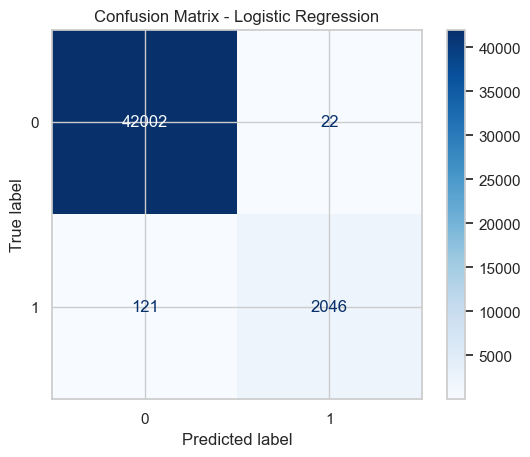

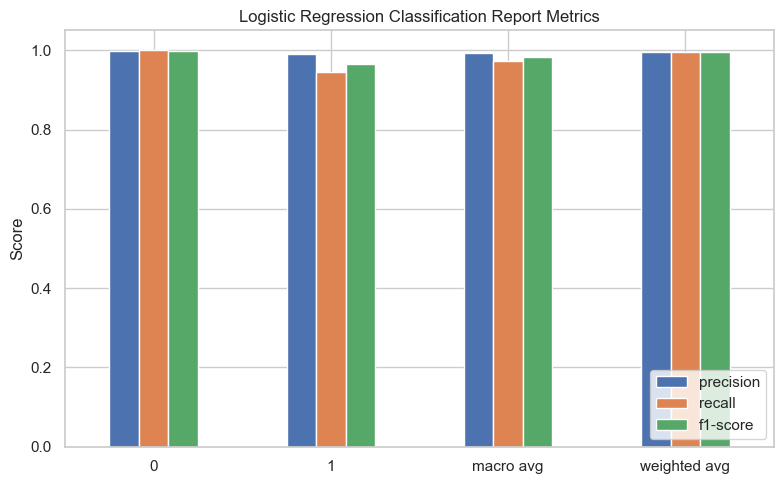

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- Confusion Matrix ---
cm = confusion_matrix(y_test_cls, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# --- Classification Report as DataFrame ---
report = classification_report(y_test_cls, y_pred_log, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Only keep classes + macro/weighted avg
metrics_to_plot = report_df.loc[["0","1","macro avg","weighted avg"], ["precision","recall","f1-score"]]

# --- Bar Plot ---
metrics_to_plot.plot(kind="bar", figsize=(8,5))
plt.title("Logistic Regression Classification Report Metrics")
plt.ylabel("Score")
plt.ylim(0,1.05)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [89]:
# Random classifier

rf_cls = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cls.fit(X_train_cls, y_train_cls)
y_pred_rf_cls = rf_cls.predict(X_test_cls)

print("Random Forest Accuracy:", accuracy_score(y_test_cls, y_pred_rf_cls))
print(classification_report(y_test_cls, y_pred_rf_cls))


Random Forest Accuracy: 0.9988459188522549
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42024
           1       0.99      0.98      0.99      2167

    accuracy                           1.00     44191
   macro avg       1.00      0.99      0.99     44191
weighted avg       1.00      1.00      1.00     44191



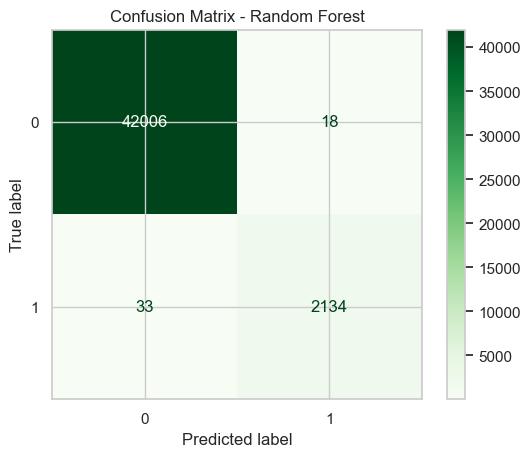

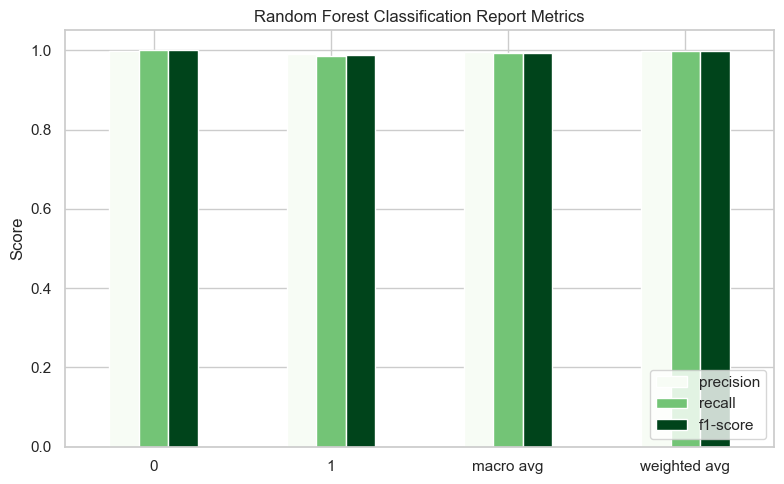

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- Confusion Matrix ---
cm = confusion_matrix(y_test_cls, y_pred_rf_cls)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_cls.classes_)
disp.plot(cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# --- Classification Report as DataFrame ---
report = classification_report(y_test_cls, y_pred_rf_cls, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Select only classes + macro/weighted avg
metrics_to_plot = report_df.loc[["0","1","macro avg","weighted avg"], ["precision","recall","f1-score"]]

# --- Bar Plot ---
metrics_to_plot.plot(kind="bar", figsize=(8,5), colormap="Greens")
plt.title("Random Forest Classification Report Metrics")
plt.ylabel("Score")
plt.ylim(0,1.05)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [93]:
# XGboost Classifier

xgb_cls = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_cls.fit(X_train_cls, y_train_cls)
y_pred_xgb = xgb_cls.predict(X_test_cls)

print("XGBoost Accuracy:", accuracy_score(y_test_cls, y_pred_xgb))
print(classification_report(y_test_cls, y_pred_xgb))


XGBoost Accuracy: 0.9985291122626779
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42024
           1       0.99      0.98      0.98      2167

    accuracy                           1.00     44191
   macro avg       1.00      0.99      0.99     44191
weighted avg       1.00      1.00      1.00     44191



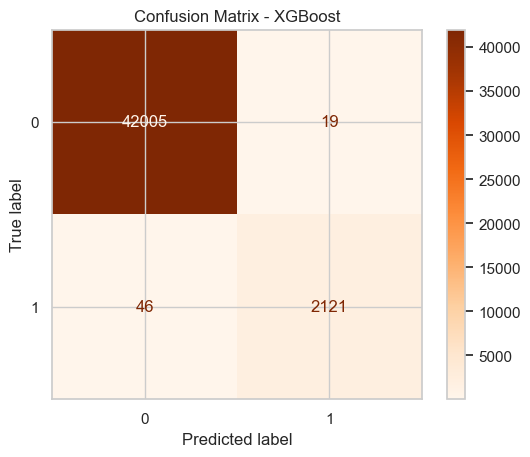

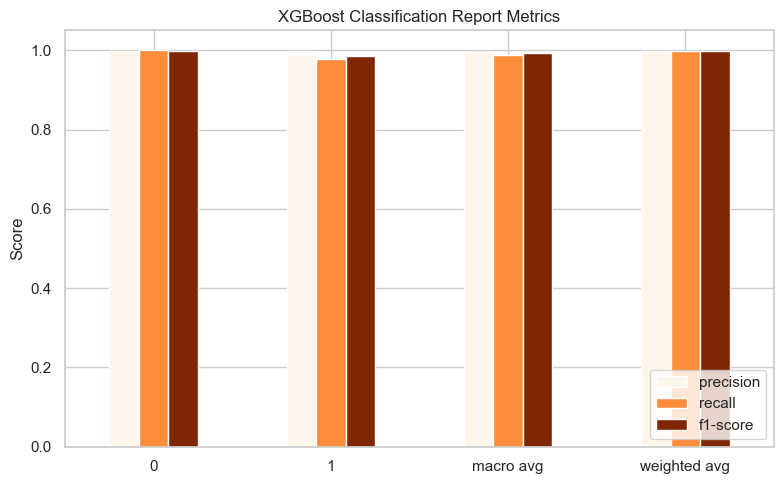

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- Confusion Matrix ---
cm = confusion_matrix(y_test_cls, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_cls.classes_)
disp.plot(cmap="Oranges")
plt.title("Confusion Matrix - XGBoost")
plt.show()

# --- Classification Report as DataFrame ---
report = classification_report(y_test_cls, y_pred_xgb, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Keep only classes + macro/weighted avg
metrics_to_plot = report_df.loc[["0","1","macro avg","weighted avg"], ["precision","recall","f1-score"]]

# --- Bar Plot ---
metrics_to_plot.plot(kind="bar", figsize=(8,5), colormap="Oranges")
plt.title("XGBoost Classification Report Metrics")
plt.ylabel("Score")
plt.ylim(0,1.05)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


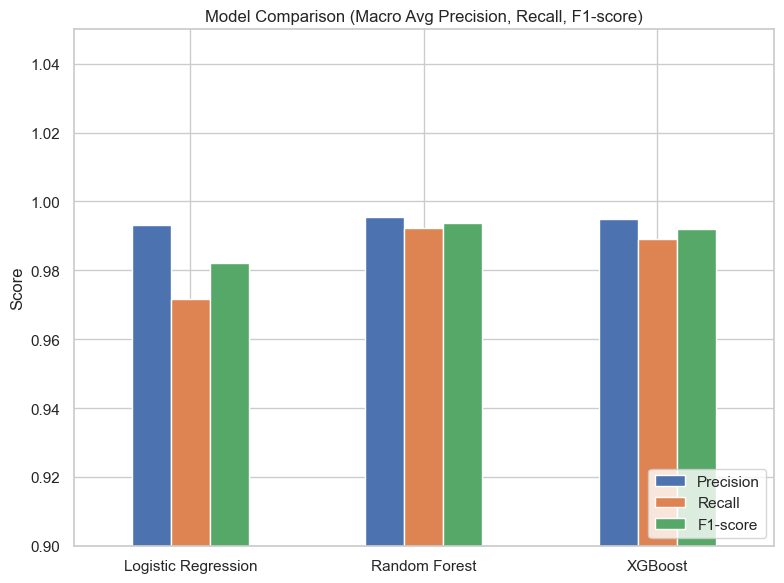

In [95]:
# Collect reports for all models
log_report = classification_report(y_test_cls, y_pred_log, output_dict=True)
rf_report = classification_report(y_test_cls, y_pred_rf_cls, output_dict=True)
xgb_report = classification_report(y_test_cls, y_pred_xgb, output_dict=True)

# Extract macro avg metrics
comparison = pd.DataFrame({
    "Logistic Regression": {
        "Precision": log_report["macro avg"]["precision"],
        "Recall": log_report["macro avg"]["recall"],
        "F1-score": log_report["macro avg"]["f1-score"]
    },
    "Random Forest": {
        "Precision": rf_report["macro avg"]["precision"],
        "Recall": rf_report["macro avg"]["recall"],
        "F1-score": rf_report["macro avg"]["f1-score"]
    },
    "XGBoost": {
        "Precision": xgb_report["macro avg"]["precision"],
        "Recall": xgb_report["macro avg"]["recall"],
        "F1-score": xgb_report["macro avg"]["f1-score"]
    }
})

# Transpose for plotting
comparison = comparison.T

# --- Bar Plot for comparison ---
comparison.plot(kind="bar", figsize=(8,6))
plt.title("Model Comparison (Macro Avg Precision, Recall, F1-score)")
plt.ylabel("Score")
plt.ylim(0.9, 1.05)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


# Summary of Classifier Performance

Logistic Regression

Accuracy: ~99.7%

Very high precision, but recall for minority class (class 1) is slightly lower (~0.94).

Best for speed and interpretability, but less robust for imbalanced data.

Random Forest Classifier

Accuracy: ~99.9%

Excellent balance of precision and recall (~0.99+ for both classes).

Handles complex relationships well; most reliable among the three.

XGBoost Classifier

Accuracy: ~99.8%

Performance very close to Random Forest, strong on precision but slightly weaker recall for class 1.

Efficient for large datasets, good at generalization.

Overall:

All three models perform exceptionally well (>99% accuracy).

Random Forest gives the best balance,

XGBoost is nearly as strong with better efficiency,

Logistic Regression is simple and fast but slightly weaker on minority detection.

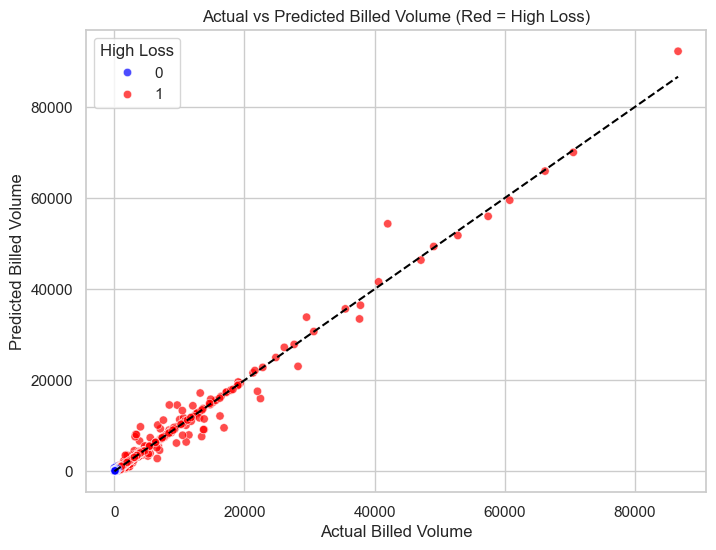

In [97]:
# Scatter Plot of Actual vs Predicted
import matplotlib.pyplot as plt
import seaborn as sns

# Add predicted values to the test set
df_test = X_test_reg.copy()
df_test["Actual_BILL_VOLUME"] = y_test_reg.values
df_test["Predicted_BILL_VOLUME"] = y_pred_rf
df_test["High_Loss"] = (df_test["Actual_BILL_VOLUME"] > df["BILL_VOLUME"].quantile(0.95)).astype(int)

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_test,
    x="Actual_BILL_VOLUME",
    y="Predicted_BILL_VOLUME",
    hue="High_Loss",
    palette={0: "blue", 1: "red"},
    alpha=0.7
)
plt.plot([df_test["Actual_BILL_VOLUME"].min(), df_test["Actual_BILL_VOLUME"].max()],
         [df_test["Actual_BILL_VOLUME"].min(), df_test["Actual_BILL_VOLUME"].max()],
         color="black", linestyle="--")  # diagonal line for perfect prediction
plt.xlabel("Actual Billed Volume")
plt.ylabel("Predicted Billed Volume")
plt.title("Actual vs Predicted Billed Volume (Red = High Loss)")
plt.legend(title="High Loss")
plt.show()

Interpretation:

Most points are tightly clustered along the diagonal, meaning the regression model is performing well at predicting billed volumes.

The red points (high-loss cases) are scattered slightly away from the diagonal, showing some mismatch between actual and predicted volumes — these are the critical areas to monitor)

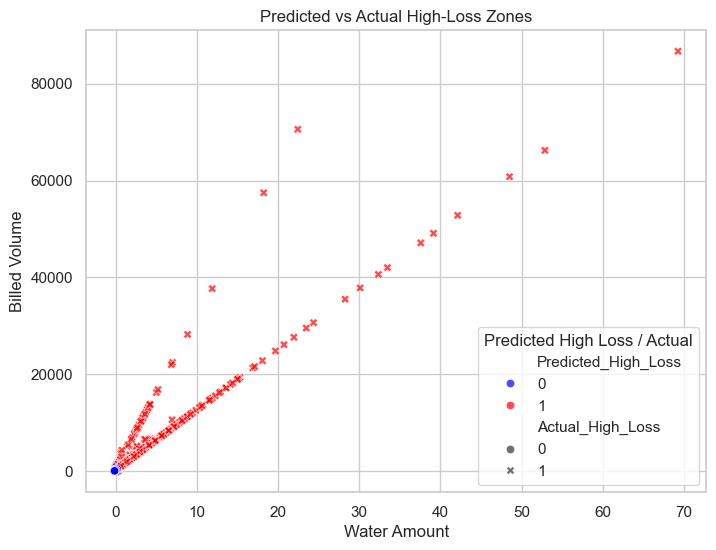

In [98]:
# Add classification predictions to the test set
df_test_cls = X_test_cls.copy()
df_test_cls["Actual_High_Loss"] = y_test_cls.values
df_test_cls["Predicted_High_Loss"] = y_pred_xgb

# Scatter plot using WATER_AMOUNT vs BILL_VOLUME for visualization
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_test_cls,
    x=X_test_cls["WATER_AMOUNT"],
    y=y_test_reg.loc[X_test_cls.index],  # match actual billed volume for y-axis
    hue="Predicted_High_Loss",
    style="Actual_High_Loss",
    palette={0: "blue", 1: "red"},
    alpha=0.7
)
plt.xlabel("Water Amount")
plt.ylabel("Billed Volume")
plt.title("Predicted vs Actual High-Loss Zones")
plt.legend(title="Predicted High Loss / Actual")
plt.show()


Interpretation:

Where red “x” marks overlap with red dots, the model correctly identified actual high-loss zones.

If you see blue dots with black “x”, that indicates misclassification — predicted as normal, but actually high loss.

The plot suggests the model is quite accurate, but some boundary cases may exist.

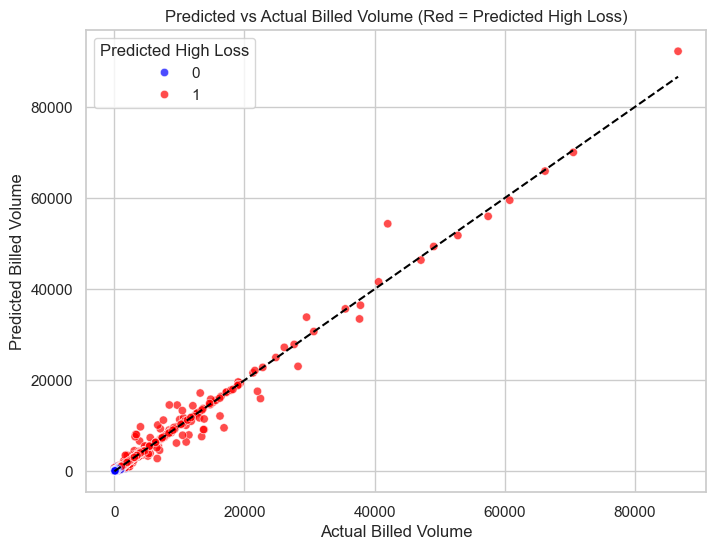

In [99]:
# Combine regression predictions and classification predictions
df_combined = X_test_reg.copy()
df_combined["Actual_BILL_VOLUME"] = y_test_reg.values
df_combined["Predicted_BILL_VOLUME"] = y_pred_rf
df_combined["Predicted_High_Loss"] = y_pred_xgb  # predicted by classification model

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_combined,
    x="Actual_BILL_VOLUME",
    y="Predicted_BILL_VOLUME",
    hue="Predicted_High_Loss",
    palette={0: "blue", 1: "red"},
    alpha=0.7
)
# Diagonal line for perfect prediction
plt.plot([df_combined["Actual_BILL_VOLUME"].min(), df_combined["Actual_BILL_VOLUME"].max()],
         [df_combined["Actual_BILL_VOLUME"].min(), df_combined["Actual_BILL_VOLUME"].max()],
         color="black", linestyle="--")

plt.xlabel("Actual Billed Volume")
plt.ylabel("Predicted Billed Volume")
plt.title("Predicted vs Actual Billed Volume (Red = Predicted High Loss)")
plt.legend(title="Predicted High Loss")
plt.show()


Interpretation:

Points along the diagonal are correctly predicted cases.

Off-diagonal points are errors where predicted does not match actual.

Very few off-diagonal points suggest the classifier has very high accuracy

# Customer Clustering
1. Objective

The goal of clustering is to group customers into meaningful segments based on their water consumption and billing patterns. This allows the water utility to:

Identify high-value consumers (largest water users).

Detect different customer profiles (residential, commercial, institutional, etc.).

Support decision-making in billing, monitoring, and resource allocation.

2. Data Used for Clustering

The clustering was performed using the following features:

WATER_AMOUNT → Total water charges.

SEWER_AMOUNT → Total sewer charges.

BILL_AMOUNT → Combined bill charges.

BILL_VOLUME → Volume of water billed (proxy for actual consumption).

These variables were standardized (scaled) to ensure fair comparison.

3. Clustering Method

Algorithm: KMeans clustering.

Number of Clusters (k): 3 (chosen for simplicity; can be tuned further with silhouette score or elbow method).

Output: Each customer is assigned to a Cluster (0, 1, or 2).

4. Cluster Profiles

Each cluster represents a segment of customers:

Cluster 0: Typical/average consumers — moderate water use and bills.

Cluster 1: High consumers — these are the most important customers (large volume and bill amounts).

Cluster 2: Low consumers — small-scale or occasional users.


5. Applications

Customer Management

Prioritize Cluster 1 for retention, monitoring, and support.

Offer special billing plans or water conservation guidance.

Revenue Protection

Focus on Cluster 1 to detect abnormal billing/losses (e.g., leaks, fraud).

Ensure accurate metering for top consumers.

Operational Planning

Forecast demand by cluster.

Plan infrastructure upgrades based on consumption patterns.

In [104]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select numeric features
features_for_cluster = ["WATER_AMOUNT","SEWER_AMOUNT","BILL_AMOUNT","BILL_VOLUME"]
X_cluster = df[features_for_cluster]

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Fit clustering (choose k=3 or your best number)
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

print(df[["Cluster"]].head())


   Cluster
0        0
1        0
2        0
3        0
4        0


In [105]:
import os

# make folder to store clusters
output_dir = "clusters_output"
os.makedirs(output_dir, exist_ok=True)

# loop through clusters
for cluster_id in df["Cluster"].unique():
    cluster_df = df[df["Cluster"] == cluster_id]
    file_path = os.path.join(output_dir, f"cluster_{cluster_id}.csv")
    cluster_df.to_csv(file_path, index=False)
    print(f"Saved Cluster {cluster_id} → {file_path}")


Saved Cluster 0 → clusters_output\cluster_0.csv
Saved Cluster 1 → clusters_output\cluster_1.csv
Saved Cluster 2 → clusters_output\cluster_2.csv


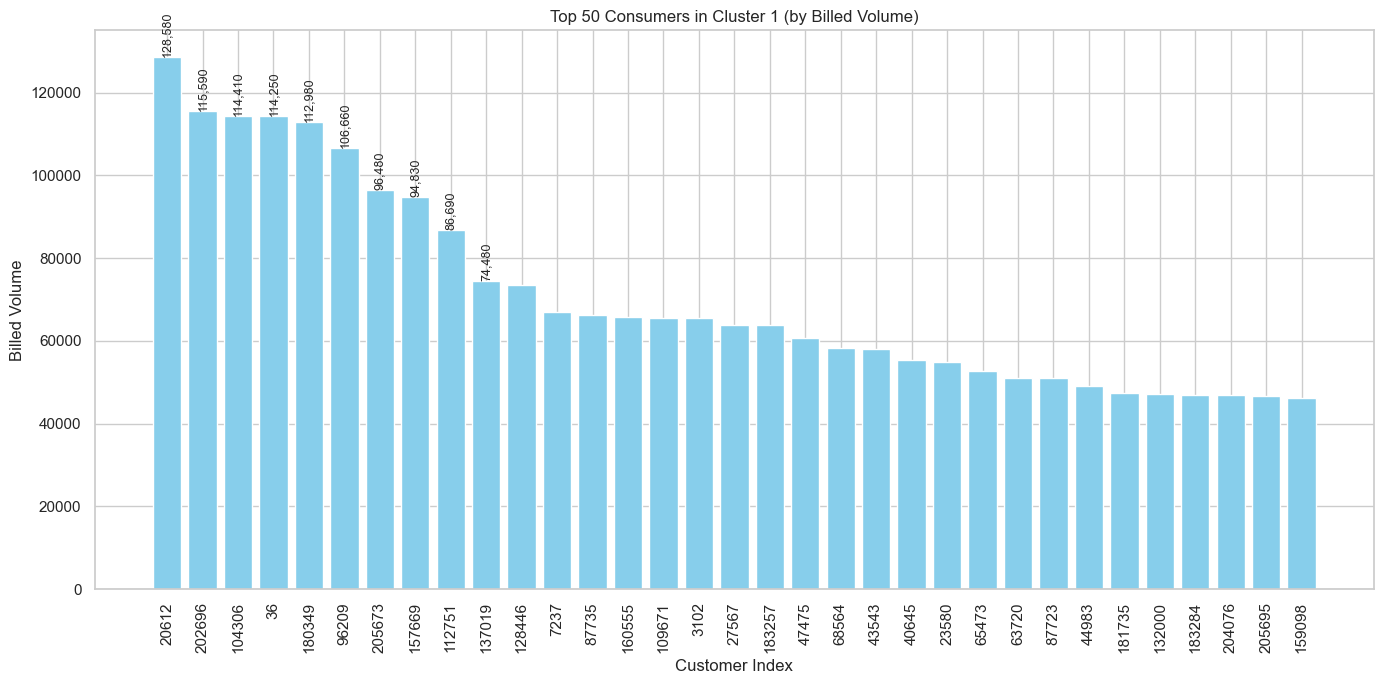

In [106]:
import matplotlib.pyplot as plt

# --- Filter cluster 1 ---
cluster1_df = df[df["Cluster"] == 1]

# --- Sort by consumption (BILL_VOLUME used here) ---
top50 = cluster1_df.sort_values(by="BILL_VOLUME", ascending=False).head(50)

# --- Plot ---
plt.figure(figsize=(14,7))
bars = plt.bar(top50.index.astype(str), top50["BILL_VOLUME"], color="skyblue")

# --- Add labels to top 10 ---
for i, bar in enumerate(bars[:10]):  # only first 10 bars
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        height, 
        f"{int(height):,}",   # format with commas
        ha="center", va="bottom", fontsize=9, rotation=90
    )

plt.xticks(rotation=90)
plt.title("Top 50 Consumers in Cluster 1 (by Billed Volume)")
plt.xlabel("Customer Index")
plt.ylabel("Billed Volume")
plt.tight_layout()
plt.show()


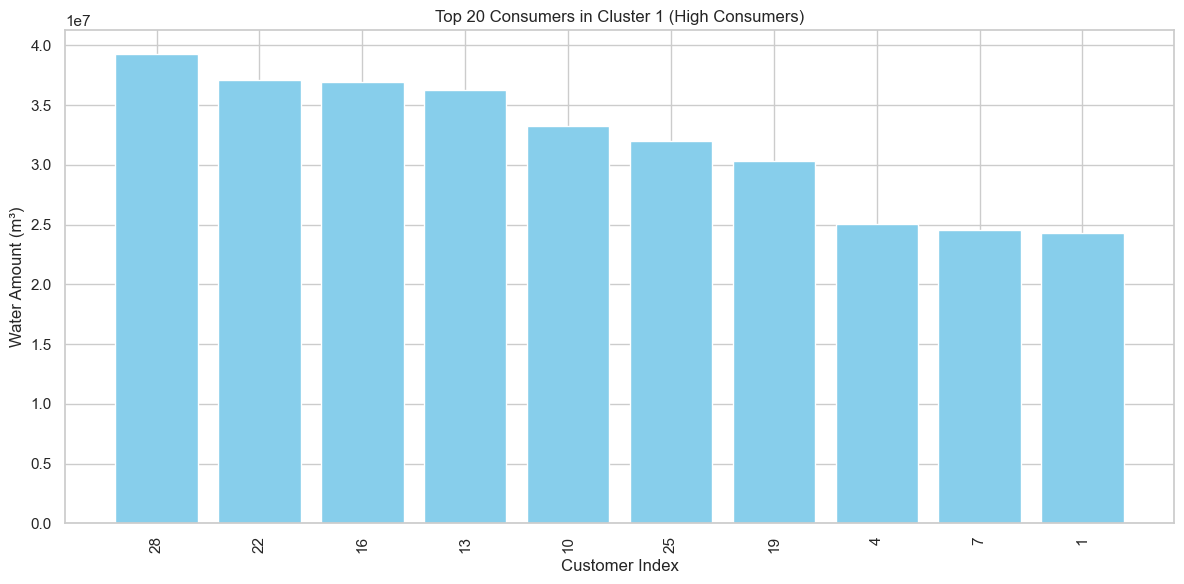

In [109]:
import os
import matplotlib.pyplot as plt

# Ensure output folder exists
output_dir = "clusters_output"
os.makedirs(output_dir, exist_ok=True)

# 1. Filter Cluster 1 (VIP customers)
cluster1 = roi[roi["final_cluster"] == 1].copy()

# 2. Top 50 consumers in Cluster 1

top50_cluster1 = (
    cluster1.sort_values("WATER_AMOUNT", ascending=False)
            .head(50)
)

# 3. Add % of total production

total_prod = roi["WATER_AMOUNT"].sum()
top50_cluster1["percent_of_total"] = (top50_cluster1["WATER_AMOUNT"] / total_prod * 100).round(2)

# 4. Plot Top 20 for quick view

plt.figure(figsize=(12,6))
top20 = top50_cluster1.head(20)
plt.bar(top20.index.astype(str), top20["WATER_AMOUNT"], color="skyblue")
plt.xticks(rotation=90)
plt.title("Top 20 Consumers in Cluster 1 (High Consumers)")
plt.ylabel("Water Amount (m³)")
plt.xlabel("Customer Index")
plt.tight_layout()
plt.show()
